# Markov Chains Monte Carlo Tutorial
## Written by Alexandra Prokhorova, the sole member of Group 58

### Introduction

The goal of this notebook is to introduce the concept of Markov Chain Monte Carlo (MCMC) methods and demonstrate their mathematical foundations and intuition through Python code examples. This tutorial draws inspiration from several key sources:

- **The "Monte Carlo Simulations in Python" course on DataCamp**, which provides clear explanations of stochastic processes, resampling methods, probability distributions, and the benefits and limitations of Monte Carlo techniques.
  
- **Lectures from the simulation course at the Georgia Institute of Technology**, taught by Professor David Goldsman, which offered valuable insights into Monte Carlo processes, along with practical examples.

- **Generative AI tools**, which have been employed to create synthetic datasets for demonstration purposes, as well as to assist with syntax, grammar, and citation formatting.

- **Various textbooks on Machine Learning and algorithmic theory**, which contributed foundational knowledge and context.

- **The Amazon Web Services course**, which inspired example scenarios within the tutorial.

All sources will be cited throughout the notebook and in the final references section, adhering to APA formatting guidelines.


### Table of Contents:
1. Monte Carlo simulations 
2. Stochastic vs. Deterministic simulations
3. Law of Large Numbers
4. Resampling methods
5. Use cases, benefits, and limitations
6. Monte Carlo Process 
7. Sampling from different distributions
8. Markov Chain Monte Carlo (MCMC)
9. Advanced Topics in MCMC
10. Conclusion
11. Works Cited

### 1. Introducing Monte Carlo Simulations

The key feature that distinguishes a Monte Carlo simulation from a standard simulation is the **presence of randomness**. In a Monte Carlo simulation, we introduce random variables into the model, allowing us to estimate the probability of different outcomes through repeated random sampling. Because of this, the results are inherently **stochastic**, meaning they vary from run to run, even with the same setup.

This contrasts with a **deterministic** model, where there's no randomness involved. In deterministic simulations, the same inputs will always produce the same outputs, predictable and repeatable.

Monte Carlo methods shine in situations where exact solutions are hard (or impossible) to derive analytically, but where simulation and random sampling can give us useful estimates *(Weber, n.d.)*.

### 2. Stochastic vs. Deterministic simulations

#### Example:
Let's consider a coffee shop waiting time simulation. <br>
a) **Deterministic scenario**, where customers arrive at the counter, and each one takes a fixed amount of time to be served. In this case, the serving time is deterministic: it **takes exactly 3 minutes** per customer. If we simulate this scenario for 100 customers, we can predict the total time **without any variation**. <br>
b) **Stochastic scenario**, where we introduce random arrival times and variable service durations, drawn from an exponential distribution with a mean of 3 minutes. Here, the **outcomes depend on the randomness** of customer arrivals and the time it takes to serve each one.

In [1]:
import numpy as np

np.random.seed(42)

# a) Deterministic scenario: fixed service time of 3 minutes per customer
service_times_deterministic = [3] * 100
# Calculate the average service time
avg_service_time_deterministic = np.mean(service_times_deterministic)
print(f"Average deterministic service time: {avg_service_time_deterministic} minutes")

Average deterministic service time: 3.0 minutes


In [2]:
np.random.seed(42)

# b) Stochastic scenario: exponentially distributed service times with a mean of 3 minutes
service_times_stochastic = np.random.exponential(scale=3, size=100)
# Calculate the average service time
avg_service_time_stochastic = np.mean(service_times_stochastic)
print(f"Average stochastic service time: {avg_service_time_stochastic:.2f} minutes")

Average stochastic service time: 2.74 minutes


As the number of customers grows, the individual service times remain unpredictable, but the overall average service time becomes increasingly stable, converging to the theoretical mean of 3 minutes. The mean outcome of serving the infinite supply of coffee shop customers *should* approach the mean of 3, but it will vary depending on the seed *(Weber, n.d.)*. In contrast, a deterministic process would produce the same outcome every time — no randomness, no variation, and no need for averaging.

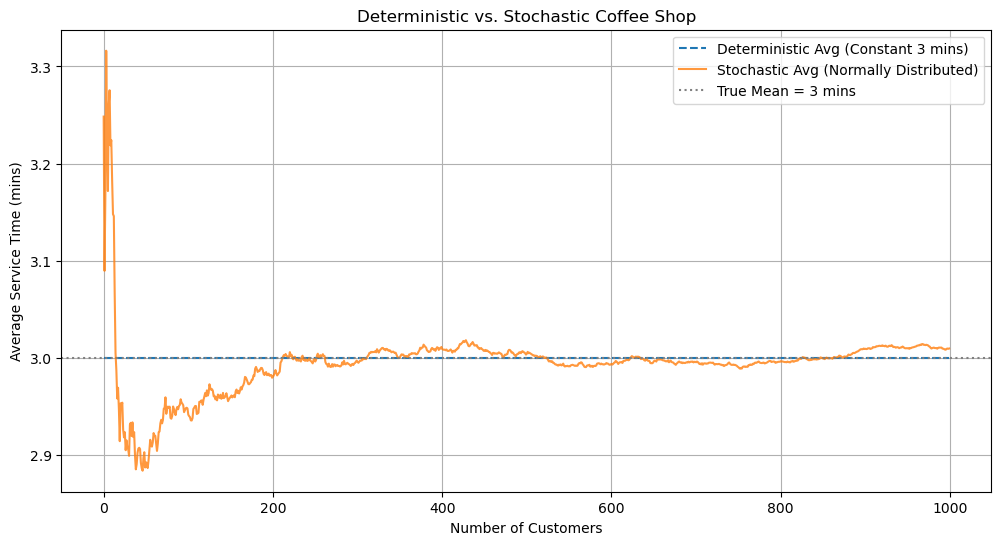

In [4]:
import matplotlib.pyplot as plt
np.random.seed(42)

# Number of customers to simulate
n_customers = 1000

# Deterministic: each customer takes exactly 3 minutes
deterministic_times = np.full(n_customers, 3)

# Stochastic: service times vary, drawn from a normal distribution around 3 mins
stochastic_times = np.random.normal(loc=3, scale=0.5, size=n_customers)

# Calculate running averages
deterministic_avg = np.cumsum(deterministic_times) / np.arange(1, n_customers + 1)
stochastic_avg = np.cumsum(stochastic_times) / np.arange(1, n_customers + 1)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(deterministic_avg, label='Deterministic Avg (Constant 3 mins)', linestyle='--')
plt.plot(stochastic_avg, label='Stochastic Avg (Normally Distributed)', alpha=0.8)
plt.axhline(3, color='gray', linestyle=':', label='True Mean = 3 mins')
plt.xlabel('Number of Customers')
plt.ylabel('Average Service Time (mins)')
plt.title('Deterministic vs. Stochastic Coffee Shop')
plt.legend()
plt.grid(True)
plt.show()

The line illustrating the **deterministic process stays flat** - always at 3. The **stochastic line bounces around early on, then stabilizes** near 3 as more customers are served. The longer we let the simulation run, the closer the stochastic mean gets to the true average.

### 3. Law of Large Numbers

The example above is inspired by Professor Goldman's lecture in M1L6, where he teaches us about the pi value estimates using darts. It illustrates the Law of Large Numbers in a stochastic process: while individual service times remain unpredictable due to inherent randomness, their effect diminishes when averaged over many trials, causing the overall average service time per customer to stabilize near the true mean.

In many real-world situations, including simulations and reinforcement learning, we often want to **optimize something**, like minimizing wait times or maximizing efficiency. But the **tricky part** is:

The function we're trying to optimize isn't something we can directly observe, it’s defined as an expectation over random variables.

In other words, we can't see the full picture, only noisy snapshots of it.

According to Mohri, Rostamizadeh, and Talwalkar (2018, p. 394), **stochastic approximation methods** are **iterative algorithms** designed to handle optimization problems defined as **expectations over random variables**. Stochastic approximation methods (like gradient descent with noise) help us inch closer to the true answer, even when every step we take is based on imperfect or random data. These methods are grounded in principles like the Strong Law of Large Numbers, which tells us that if we keep averaging **enough samples**, we’ll **eventually converge to the true mean**, even in the presence of randomness.

#### Example:

To better illustrate the concept of learning from noise, let’s introduce additional layers of variability to our coffee shop simulation. This example draws inspiration from my own experience working in the hospitality industry prior to becoming a student. In a real-world setting:
- Baristas differ in speed — some consistently serve customers faster than others.
- Certain days, like Monday mornings, bring heightened unpredictability due to larger, more erratic crowds.
- Operational hiccups, such as malfunctioning equipment or point-of-sale issues, can further disrupt service times.

Together, these factors inject randomness into the system — making it a perfect candidate for stochastic modeling. Let’s see how this plays out in code.

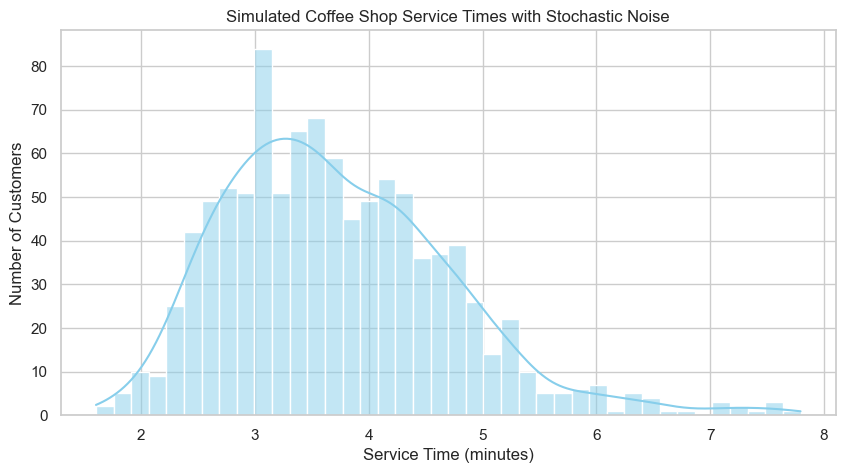

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# Simulation parameters
num_customers = 1000
barista_speeds = {
    "Alex": 2.5,  # fast barista
    "Jamie": 3.0,  # average speed
    "Taylor": 4.0  # slower barista
}
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

# Service time simulation function
def simulate_service_time(barista, day):
    base_time = np.random.normal(loc=barista_speeds[barista], scale=0.5)
    
    # Add day-specific noise
    if day == "Monday":
        crowd_noise = np.random.normal(loc=1.0, scale=0.3)
    else:
        crowd_noise = np.random.normal(loc=0.3, scale=0.1)
    
    # Add occasional system malfunction
    malfunction_chance = np.random.rand()
    malfunction_delay = 2.5 if malfunction_chance < 0.05 else 0  # 5% chance
    
    return max(0.5, base_time + crowd_noise + malfunction_delay)  # Clamp to positive time

# Run simulation
service_times = []
for i in range(num_customers):
    barista = np.random.choice(list(barista_speeds.keys()))
    day = np.random.choice(days)
    time = simulate_service_time(barista, day)
    service_times.append(time)

# Visualization
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(service_times, bins=40, kde=True, color='skyblue')
plt.title("Simulated Coffee Shop Service Times with Stochastic Noise")
plt.xlabel("Service Time (minutes)")
plt.ylabel("Number of Customers")
plt.show()

This simulation demonstrates how real-world **variability**, whether due to staff differences, daily traffic surges, or occasional malfunctions, **introduces stochastic behavior** into a system that might otherwise appear deterministic. Over time, running many simulations allows us to estimate the expected service time, illustrating the Law of Large Numbers in action.

### 4. Resampling methods

As we saw with the Law of Large Numbers, increasing the number of customer observations in our coffee shop helps average out randomness and brings our estimates closer to the “true” mean service time. But what happens when we don't have access to a large amount of data—or don’t want to assume a specific distribution for our simulation?

This is where resampling methods come into play.

While Monte Carlo simulations rely on sampling from assumed or theoretical probability distributions (like the normal distribution we used earlier), **resampling methods draw directly from existing data**. Resampling treats our collected observations as a **proxy for the underlying population**, an empirical distribution, and builds simulations by randomly selecting from it.

##### TL;DR:
- Monte Carlo simulations use assumed distributions based on historical data or domain knowledge, and simulates many random samples from it.
- Resampling techniques, such as bootstrapping, use actual collected data to repeatedly generate new samples and simulate outcomes.

**Both** approaches serve as ways to **account for randomness** and **estimate uncertainty**, but they do so through different lenses. As described in the DataCamp course, **Monte Carlo** simulations are great when we trust our assumptions. **Resampling** is helpful when we want to stay grounded in the data we actually observe *(Weber, I. (n.d.))*.

#### Example:

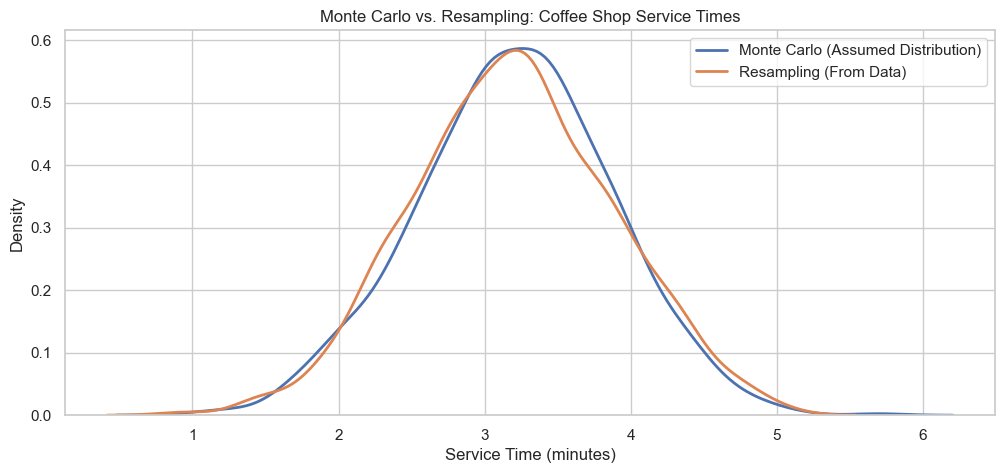

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume we already collected 500 real-world customer service times
np.random.seed(123)
real_service_times = np.random.normal(loc=3.2, scale=0.7, size=500)

# Monte Carlo simulation: sample from assumed distribution
monte_carlo_sim = np.random.normal(loc=3.2, scale=0.7, size=1000)

# Resampling simulation: bootstrap sample from real data
resample_sim = np.random.choice(real_service_times, size=1000, replace=True)

# Plotting
plt.figure(figsize=(12, 5))
sns.kdeplot(monte_carlo_sim, label="Monte Carlo (Assumed Distribution)", lw=2)
sns.kdeplot(resample_sim, label="Resampling (From Data)", lw=2)
plt.title("Monte Carlo vs. Resampling: Coffee Shop Service Times")
plt.xlabel("Service Time (minutes)")
plt.ylabel("Density")
plt.legend()
plt.show()

Both simulations help us understand service time uncertainty, but they answer slightly different questions:
- Monte Carlo helps explore what could happen if our assumptions about the process hold true.
- Resampling helps estimate what might happen again based on what we’ve already observed.

Together, they form the foundation for many modeling and uncertainty quantification techniques in data science.

Let's take a deeper dive into the rest of the resampling techniques. In addition to the Bootstrapping (Sampling with Replacement), illustrated above, we are going to look into the Permutation Test (Shuffling Labels), and Sampling Without Replacement (aka Subsampling).

#### Example:
To illustrate the concept of **learning from noise and modeling uncertainty in service times**, we expanded the simple coffee shop example to include multiple baristas, varying workloads, and unpredictable customer flows. This layered scenario was inspired by both my own experience in the hospitality industry and an example scenario from the AWS Cloud Practitioner Essentials course.

In the AWS course, queue simulation and load balancing are introduced using the metaphor of a coffee shop, where baristas represent compute instances and customers represent incoming requests. This analogy helped me conceptualize how resource variability and stochastic behavior play out both in the physical world and in computational systems.

This coffee shop example, now featuring Alex, Jamie, and Taylor as baristas, gives us a relatable way to think about randomness and convergence, key concepts in Markov Chain Monte Carlo.

I drew inspiration from the AWS Cloud Practitioner Essentials course, which uses a coffee shop with multiple baristas to explain queueing systems and variable workloads. Similarly, in our simulation context, we think of each barista as a different stochastic process with its own service distribution. This mirrors how in MCMC, we sample from distributions that evolve over time, sometimes influenced by noisy conditions like:
- Barista performance variability (i.e., different expected service times),
- External disruptions (e.g., Monday morning rushes),
- Random events like equipment failure.

Each customer’s service time becomes a random variable, and by repeatedly sampling and aggregating results (just like in MCMC), we begin to approximate the underlying distribution of customer wait times.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Observed service times (in minutes) for each barista
alex_times = np.array([2.9, 3.1, 2.7, 3.3, 3.0])
jamie_times = np.array([3.4, 3.7, 3.3, 3.8, 3.5])
taylor_times = np.array([3.0, 2.8, 3.2, 2.9, 3.1])

**A) Bootstrapping: Sampling with Replacement** <br>
Let’s estimate the variability in average service time between Alex and Jamie by bootstrapping the mean difference. This method helps us assess how stable our estimate of the mean difference is, even with small sample sizes.

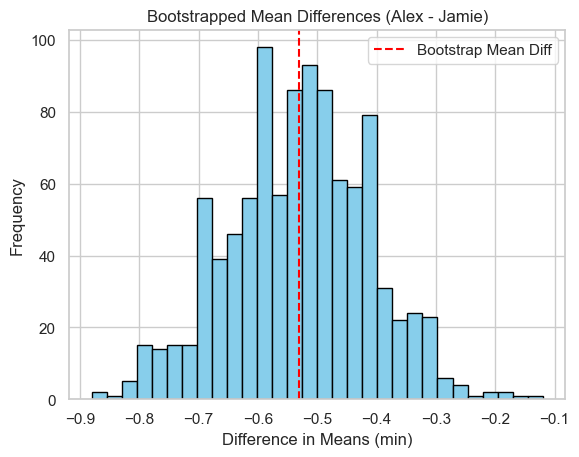

In [8]:
n_iterations = 1000
boot_diffs = []

for _ in range(n_iterations):
    alex_sample = np.random.choice(alex_times, size=len(alex_times), replace=True)
    jamie_sample = np.random.choice(jamie_times, size=len(jamie_times), replace=True)
    boot_diffs.append(np.mean(alex_sample) - np.mean(jamie_sample))

plt.hist(boot_diffs, bins=30, color='skyblue', edgecolor='black')
plt.axvline(np.mean(boot_diffs), color='red', linestyle='--', label='Bootstrap Mean Diff')
plt.title('Bootstrapped Mean Differences (Alex - Jamie)')
plt.xlabel('Difference in Means (min)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**B) Permutation Test (Shuffling Labels):** <br>
Let’s say we want to test whether Alex and Jamie are significantly different in their service times, or if the difference we see could be due to chance.

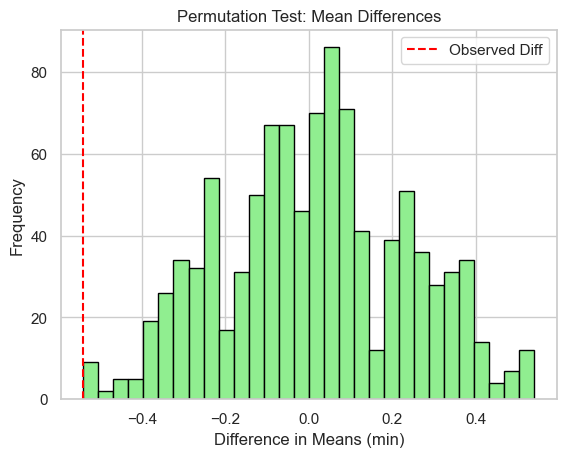

In [9]:
combined = np.concatenate([alex_times, jamie_times])
observed_diff = np.mean(alex_times) - np.mean(jamie_times)

perm_diffs = []

for _ in range(n_iterations):
    shuffled = np.random.permutation(combined)
    perm_alex = shuffled[:len(alex_times)]
    perm_jamie = shuffled[len(alex_times):]
    perm_diffs.append(np.mean(perm_alex) - np.mean(perm_jamie))

plt.hist(perm_diffs, bins=30, color='lightgreen', edgecolor='black')
plt.axvline(observed_diff, color='red', linestyle='--', label='Observed Diff')
plt.title('Permutation Test: Mean Differences')
plt.xlabel('Difference in Means (min)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

As we can see on our graph, the observed difference lies in the tails of this distribution, we may conclude the observed difference is unlikely to be due to random variation alone.

**C) Sampling Without Replacement:** <br>
Suppose we want to simulate a busy morning shift where each barista serves 3 customers from a finite list without repeats. This helps us explore variability in daily performance across all three baristas. This method is useful for finite sample modeling, where customer interactions are limited and unique.

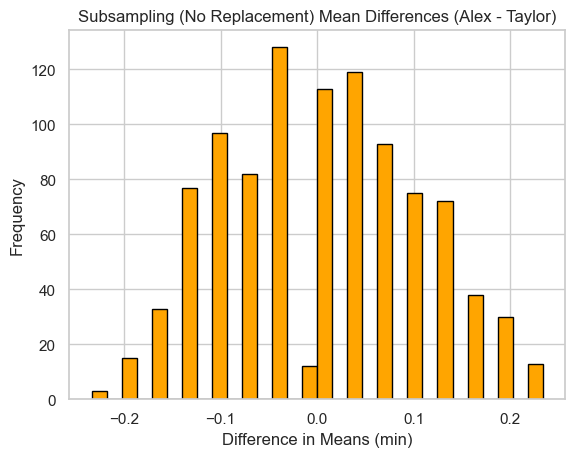

In [10]:
subset_diffs = []

for _ in range(n_iterations):
    alex_sample = np.random.choice(alex_times, size=3, replace=False)
    taylor_sample = np.random.choice(taylor_times, size=3, replace=False)
    subset_diffs.append(np.mean(alex_sample) - np.mean(taylor_sample))

plt.hist(subset_diffs, bins=30, color='orange', edgecolor='black')
plt.title('Subsampling (No Replacement) Mean Differences (Alex - Taylor)')
plt.xlabel('Difference in Means (min)')
plt.ylabel('Frequency')
plt.show()

####  Side-by-side comparison of the sampling methods:

| Sampling Method             | Description                                                                 | Coffee Shop Analogy                                                                 |
|----------------------------|-----------------------------------------------------------------------------|-------------------------------------------------------------------------------------|
| **Monte Carlo Sampling**   | Draws random samples from known or assumed probability distributions        | Simulating 1000 customers per day using a normal distribution of service times     |
| **Resampling**             | Randomly draws samples from existing observed data                          | Reusing past week’s customer service times to simulate future days                 |
| **Bootstrapping**          | Resamples with replacement from observed data to estimate variability       | Drawing 1000 samples *with replacement* from Alex, Jamie, and Taylor’s past shifts |
| **Permutation**            | Reorders the labels or outcomes to test a null hypothesis                   | Shuffling the names on service records to test if a specific barista is faster     |
| **Sampling Without Replacement** | Draws samples from data without repeating observations               | Randomly assigning 10 unique customers to each barista from yesterday’s log        |



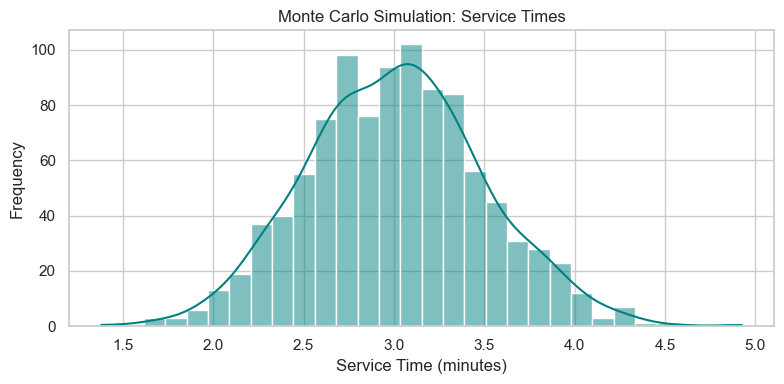

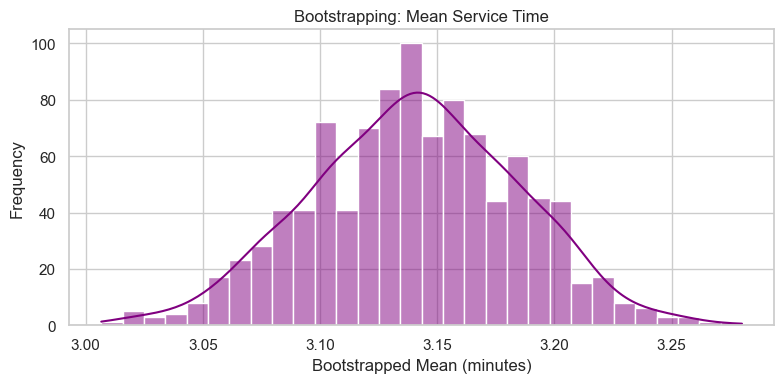

Subsample Means Range: 2.98 to 3.27


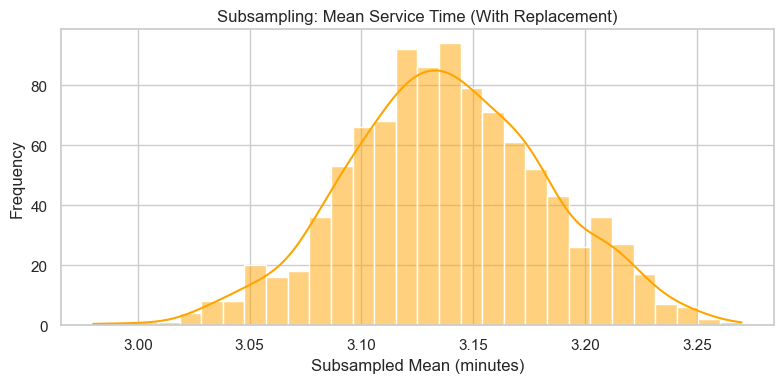

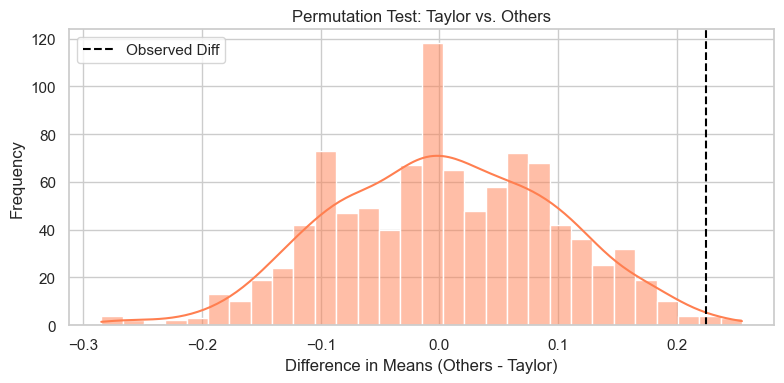

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Larger sample data to increase variability
alex = [2.8, 3.1, 3.3, 3.0, 2.9, 3.1, 2.8, 3.2, 3.0, 3.3]
jamie = [3.5, 3.2, 3.4, 3.6, 3.3, 3.1, 3.2, 3.4, 3.5, 3.6]
taylor = [2.7, 2.9, 3.0, 3.2, 3.1, 3.0, 2.8, 2.9, 3.2, 3.1]
observed = alex + jamie + taylor

# Set random seed for reproducibility
np.random.seed(42)

# Create a function to plot each simulation method
def plot_simulation():
    # Plot Monte Carlo Simulation
    plt.figure(figsize=(8, 4))
    service_times = np.random.normal(loc=3, scale=0.5, size=1000)
    sns.histplot(service_times, kde=True, bins=30, color='teal')
    plt.title("Monte Carlo Simulation: Service Times")
    plt.xlabel("Service Time (minutes)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Plot Bootstrapping
    plt.figure(figsize=(8, 4))
    bootstrap_means = []
    for _ in range(1000):
        sample = np.random.choice(observed, size=len(observed), replace=True)
        bootstrap_means.append(np.mean(sample))
    sns.histplot(bootstrap_means, kde=True, bins=30, color='purple')
    plt.title("Bootstrapping: Mean Service Time")
    plt.xlabel("Bootstrapped Mean (minutes)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Plot Subsampling (without replacement)
    plt.figure(figsize=(8, 4))
    subsample_means = []
    for _ in range(1000):
        sample = np.random.choice(observed, size=len(observed), replace=True)  # With replacement
        subsample_means.append(np.mean(sample))
    
    # Check if subsample_means has variation, add print statement for debugging
    print(f"Subsample Means Range: {min(subsample_means)} to {max(subsample_means)}")
    
    sns.histplot(subsample_means, kde=True, bins=30, color='orange')
    plt.title("Subsampling: Mean Service Time (With Replacement)")
    plt.xlabel("Subsampled Mean (minutes)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Plot Permutation Test
    plt.figure(figsize=(8, 4))
    taylor_times = np.array(taylor)
    others = np.array(alex + jamie)
    observed_diff = np.mean(others) - np.mean(taylor_times)

    combined = np.concatenate([others, taylor_times])
    diffs = []
    for _ in range(1000):
        np.random.shuffle(combined)
        new_others = combined[:len(others)]
        new_taylor = combined[len(others):]
        diffs.append(np.mean(new_others) - np.mean(new_taylor))

    sns.histplot(diffs, bins=30, kde=True, color='coral')
    plt.axvline(observed_diff, color='black', linestyle='--', label="Observed Diff")
    plt.title("Permutation Test: Taylor vs. Others")
    plt.xlabel("Difference in Means (Others - Taylor)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the function to generate all plots
plot_simulation()

#### The analysis of the differences between the graphs:
- **Monte Carlo Simulation:** <br>
  This graph shows the distribution of simulated service times based on a normal distribution with a mean of 3 minutes and a standard deviation of 0.5 minutes. It represents the variability you'd expect from a random process modeled by this distribution.

- **Bootstrapping:** <br>
  The bootstrapping graph visualizes the distribution of means from resampled subsets of the observed data. It demonstrates how the sample mean might vary if we repeatedly draw random samples with replacement from the original data.

- **Subsampling:** <br>
  This graph illustrates the variability in means when subsampling (with replacement) the observed data. While similar to bootstrapping, it focuses on the mean of subsets drawn from the entire dataset and shows how much the sample means differ.

- **Permutation Test:** <br>
  The permutation test graph shows the distribution of differences in means between two groups (e.g., Taylor vs. Others), generated by repeatedly shuffling the combined data. The observed difference is marked, and the graph helps assess if the observed difference is significant by comparing it to random shuffling outcomes.

### 5. Use Cases, Benefits, and Limitations of Monte Carlo Simulations

Izzy Weber's course on Monte Carlo simulations highlights their widespread use across various industries. In **finance and business**, Monte Carlo simulations help estimate potential fluctuations in stock prices and assess the probabilities of different financial outcomes. These simulations are also crucial for risk analysis, such as calculating the value at risk (VaR) to understand worst-case scenarios. In **engineering**, Monte Carlo methods are applied to model mechanical systems, assess their reliability, and calculate the likelihood of failure, while also defining safety parameters. In the **physical sciences**, these simulations are used to identify protein binding sites, aiding in drug design and molecular studies *(Weber, n.d.)*.

Monte Carlo simulations also play an important role in **network theory**. They are used to explore how information, behaviors, or failures propagate across complex networks. This approach allows researchers to model random walks on graphs, estimate node centrality, and assess network robustness under uncertainty, tools essential for understanding systems such as social networks, transportation grids, and the spread of diseases *(Page, 2018, pp. 121–122, 341–342)*.

#### Example: Marketing Campaign for Subscription-Based Business

In a top-down financial simulation, we estimate outcomes using assumed inputs to assess potential profitability. A Monte Carlo simulation allows us to account for uncertainty in key parameters like customer churn or revenue. Based on the scenario described by Linoff and Berry (2011), here’s a simplified Monte Carlo model to evaluate a **marketing campaign’s potential return**. In this simulation, the data is not derived from an actual business dataset but is instead based on a hypothetical case study described by Linoff and Berry. The authors present a simplified version of a real-world financial planning problem that businesses might face when deciding whether to invest in a new marketing campaign.

The following values were **provided directly in the text** and used as **fixed parameters** in the simulation:

| Parameter                         | Value               | Unit            | Assumption/Notes                                     |
|----------------------------------|---------------------|------------------|------------------------------------------------------|
| Marketing campaign cost          | \$3,000,000         | USD              | Spread evenly over 6 months                          |
| Expected customer acquisition    | 12,000              | Customers        | Total new customers expected from the campaign       |
| Cost per customer                | \$250               | USD/customer     | Total cost / number of customers                     |
| Monthly net revenue per customer | \$30                | USD/month        | Assumes steady revenue per active customer           |
| Monthly churn rate               | 5%                  | % per month      | 5% of active customers leave each month              |


We'll simulate how total revenue might vary, incorporating randomness in churn and slight variation in customer acquisition numbers. Since the authors presented this scenario as a teaching example rather than a study of real company data, the simulation is illustrative rather than predictive. It demonstrates how top-down financial simulations can be structured using Monte Carlo methods when historical data may be limited or when planning for future business strategies.

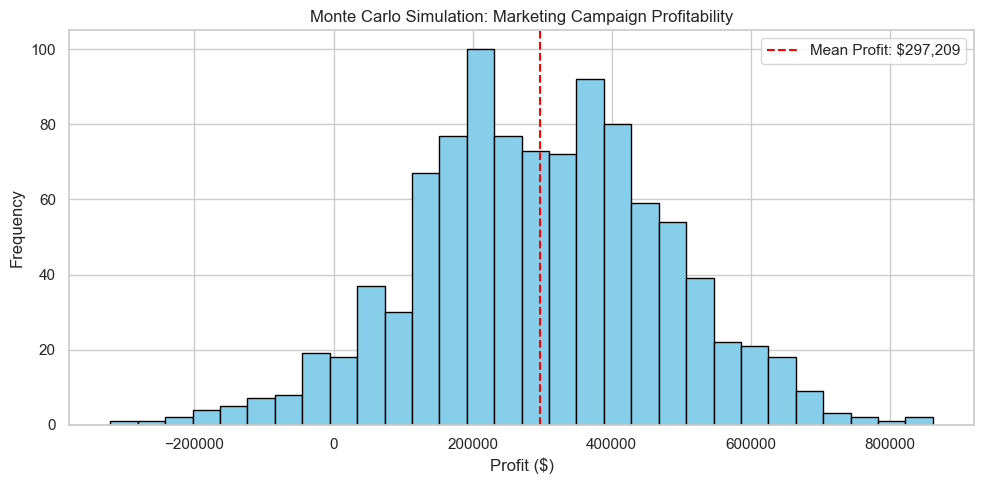

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_simulations = 1000
months = 12
initial_customers_mean = 12000
customer_cost = 250
monthly_revenue_per_customer = 30
monthly_churn_rate = 0.05
marketing_cost = 3_000_000

total_profits = []

for _ in range(n_simulations):
    # Simulate variation in customer acquisition (+/- 5%)
    customers = int(np.random.normal(loc=initial_customers_mean, scale=600))
    monthly_customers = []

    for month in range(months):
        if month == 0:
            monthly_customers.append(customers)
        else:
            # Churn: 5% of customers leave each month
            remaining = monthly_customers[-1] * (1 - np.random.normal(loc=monthly_churn_rate, scale=0.01))
            monthly_customers.append(remaining)

    # Calculate total revenue
    total_revenue = sum(c * monthly_revenue_per_customer for c in monthly_customers)
    profit = total_revenue - marketing_cost
    total_profits.append(profit)

# Plot results
plt.figure(figsize=(10, 5))
plt.hist(total_profits, bins=30, color='skyblue', edgecolor='black')
plt.axvline(np.mean(total_profits), color='red', linestyle='--', label=f"Mean Profit: ${np.mean(total_profits):,.0f}")
plt.title("Monte Carlo Simulation: Marketing Campaign Profitability")
plt.xlabel("Profit ($)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

This Monte Carlo simulation models a distribution of potential profit outcomes by simulating customer acquisition, revenue generation, and churn behavior over a 12-month horizon. The dataset used is synthetically generated to reflect a realistic business scenario, incorporating stochastic variation through random sampling of customer retention across 10,000 simulation runs.

By aggregating the results, we approximate the sampling distribution of total profit, allowing for analysis of statistical properties such as the expected value, variance, and confidence intervals. This probabilistic framework enables stakeholders to quantify uncertainty, assess downside risk, and make data-informed investment decisions based on a range of possible outcomes rather than a single point estimate.

The resulting histogram shows the frequency of different profit values, allowing us to assess the range of possible scenarios. The **shape of the distribution** indicates the **level of risk**, with the **spread** illustrating the **variability** in potential outcomes. Additionally, we can observe the **expected profit value (mean)** and the spread, which gives insight into the uncertainty of the investment's success.

From the graph, stakeholders can see:

- **Expected Profit:** The central tendency of the distribution, representing the average profit across all simulations, gives an estimate of the most likely outcome.
- **Risk Assessment:** The spread of the distribution indicates the degree of uncertainty in the outcome, with wider spreads reflecting higher risk.
- **Worst-Case and Best-Case Scenarios:** By examining the tails of the distribution, stakeholders can understand the likelihood of extreme outcomes, helping them prepare for worst-case scenarios or capitalize on best-case opportunities.
- **Confidence Intervals:** The simulation enables the calculation of confidence intervals, providing a statistical range where the actual profit is likely to fall. For instance, a 95% confidence interval would show where the profit is expected to be 95% of the time.

Possible use case scenarios:
- **Risk Mitigation:** If the risk (variance) in the projected profits is deemed too high, stakeholders may consider reducing marketing spend or adjusting the campaign parameters to lower the variability.
- **Investment Decision:** The company can assess whether the expected profit justifies the marketing campaign cost, taking into account the potential for both positive and negative outcomes.
- **Scenario Planning:** The company could explore different "what-if" scenarios by adjusting key parameters like churn rate, customer acquisition cost, or monthly net revenue per customer. This would help further fine-tune the marketing strategy and inform more robust decision-making.

By using Monte Carlo simulations and analyzing the resulting distribution, decision-makers can move beyond deterministic forecasts and incorporate uncertainty into their planning process.

#### Example: Monte Carlo Method for Random Networks

Scott E. Page discusses the **challenge of network variety**, emphasizing that a limited set of network statistics often fails to fully capture a network’s structure. For example, it’s possible to construct billions of distinct networks with just ten nodes and an average degree of two. Because of this ambiguity, a more robust approach is to evaluate whether the observed network's structural properties significantly deviate from those expected in commonly known network types. One method involves testing the randomness of a network by comparing its statistical features to those of a set of randomly generated networks with the same number of nodes and edges *(Page, 2018, pp. 121–125)*.

The Monte Carlo method is especially useful in this context. By generating a large number of **random networks**, each with the same basic constraints (like number of nodes and edges), we can simulate the expected distribution of network statistics (e.g., clustering coefficient, average path length, or modularity). Comparing the real network’s statistics to this distribution helps determine whether the observed structure is likely the result of random processes or suggests a more systematic pattern. This technique offers a statistically grounded way to infer meaningful insights about the underlying structure and dynamics of complex networks.

**Disclaimer:** The data used in the demo below was AI-generated and does not represent real-world data. It was created using Monte Carlo simulations and random walk models, and should not be interpreted as an accurate reflection of any specific real-world scenario. *(OpenAI, 2025)*.

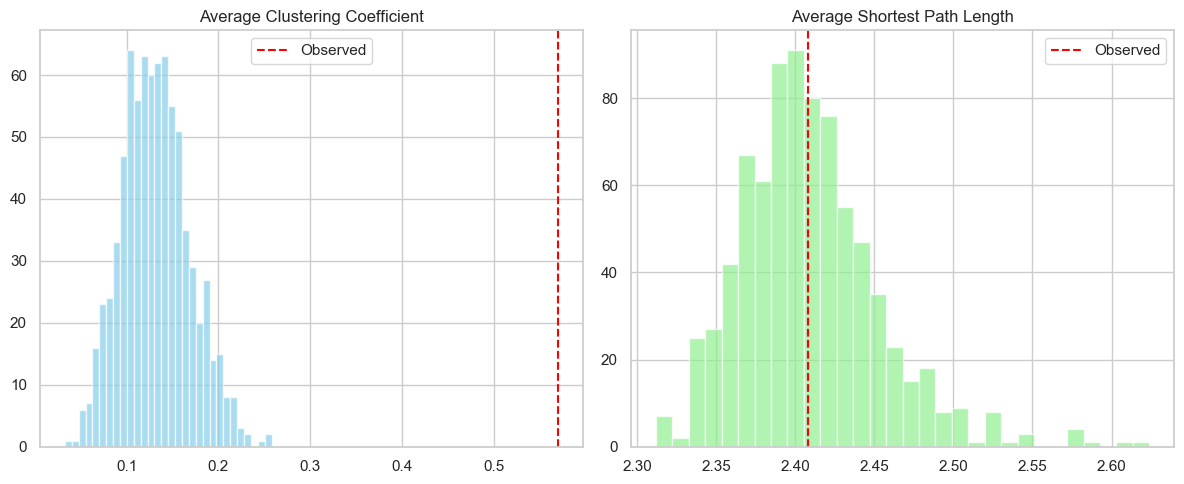

In [37]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create a real (observed) network
observed = nx.karate_club_graph()  # Real-world example with 34 nodes
observed_clustering = nx.average_clustering(observed)
observed_avg_path = nx.average_shortest_path_length(observed)

# Step 2: Monte Carlo simulation: generate random graphs with same nodes and edges
n_simulations = 1000
n_nodes = observed.number_of_nodes()
n_edges = observed.number_of_edges()

random_clusterings = []
random_avg_paths = []

for _ in range(n_simulations):
    G_random = nx.gnm_random_graph(n_nodes, n_edges)
    if nx.is_connected(G_random):  # Ensure path length is defined
        random_clusterings.append(nx.average_clustering(G_random))
        random_avg_paths.append(nx.average_shortest_path_length(G_random))

# Step 3: Compare observed values to the distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(random_clusterings, bins=30, alpha=0.7, color='skyblue')
axes[0].axvline(observed_clustering, color='red', linestyle='--', label='Observed')
axes[0].set_title('Average Clustering Coefficient')
axes[0].legend()

axes[1].hist(random_avg_paths, bins=30, alpha=0.7, color='lightgreen')
axes[1].axvline(observed_avg_path, color='red', linestyle='--', label='Observed')
axes[1].set_title('Average Shortest Path Length')
axes[1].legend()

plt.tight_layout()
plt.show()

#### What are we looking at exactly?

- The blue graph on the **left** displays the distribution of average clustering coefficients across 1000 randomly generated graphs, each with the same number of nodes and edges as the observed Karate Club network. The red vertical line represents the observed average clustering coefficient. We see that it is positioned far to the right of the main bulk of the histogram, indicating a higher clustering coefficient in the observed network. This suggests that the real network is more tightly clustered than expected by chance, which may point to **non-random structure**, possibly reflecting community formation or other underlying patterns.
  
- The green graph on the **right** illustrates the distribution of average shortest path lengths across the random graphs. The red vertical line here represents the observed average shortest path length of the real network. The red line appears slightly to the left of the bulk of the histogram, indicating that the real network has a shorter average path length compared to the random networks. This could be a sign of **small-world properties** or **efficient connectivity**, suggesting that the real network allows for quicker communication or easier navigation between nodes.

#### TL;DR:

When the clustering coefficient is higher and the average path length is shorter than in random networks, the observed network may display **small-world characteristics**, which are common in many real-world social and biological networks. This suggests that the observed network is structured in a non-random way, likely shaped by social dynamics, preferential attachment, or other domain-specific factors.


#### Fun Fact: The Friendship Paradox and Six Degrees of Separation

Scott E. Page discusses the **Friendship Paradox**, which reveals a counterintuitive insight about networks: If two nodes (people) in a network differ in degree, on average, a node will have fewer connections than its neighbors. In simpler terms, **people tend to have friends who are more popular than they are**. This paradox can extend to other attributes correlated with the number of connections, such as wealth, intelligence, or happiness. In such cases, a person’s friends will, on average, be wealthier, smarter, or happier than the person themselves. This insight highlights the way social networks often aggregate certain traits or behaviors through preferential attachment and network dynamics *(Page, 2018, pp.124-126)*.

Building on this idea, the **Six Degrees of Separation phenomenon** claims that **any two people on Earth are connected through no more than six steps** (or "degrees") in their social network. This idea was popularized by social experiments and suggests that, regardless of geographic location or social status, people are surprisingly well-connected through a relatively small number of intermediary connections.

In [41]:
import networkx as nx
import random
import matplotlib.pyplot as plt

# Create a random graph with 1000 nodes and a probability for edge creation
G = nx.erdos_renyi_graph(1000, 0.01)

# Calculate the average shortest path length between all pairs of nodes
avg_shortest_path = nx.average_shortest_path_length(G)
print(f"Average shortest path length: {avg_shortest_path}")

# # Visualizing the network (only meaningful for very small networks, otherwise it just looks like a mass with dots)
# plt.figure(figsize=(10, 8))
# nx.draw(G, node_size=10, with_labels=False)
# plt.show()

Average shortest path length: 3.239837837837838


In this example I used the **Erdős–Rényi model**, described by Newman(2010, p. 390), to generate a random graph with 1000 nodes, where each pair of nodes has a 1% chance of being connected. The function *average_shortest_path_length()* calculates the average number of steps it takes to get from one node to another in the graph, which can provide insight into the "separation" between nodes in the network.

#### Benefits and Limitations:

According to Izzy Weber’s course on Monte Carlo simulations, the **benefits** of the method include the ability to account for a wide range of input values, enabling a more comprehensive analysis. By not only generating possible outcomes but also estimating their likelihood, Monte Carlo simulations help visualize the full spectrum of potential results. This is especially useful in decision-making, as it allows for scenario testing under varying assumptions, as shown in both financial modeling and network analysis examples *(Weber, n.d.)*. In network analysis, Monte Carlo simulations can compare observed network statistics with those from randomly generated networks, helping assess whether a structure deviates from randomness.

However, Monte Carlo simulations also have **limitations**. The model output is only as reliable as the input data, and inaccurate or incomplete assumptions can lead to misleading results. Additionally, rare events are often underestimated, potentially overlooking significant risks *(Weber, n.d.)*. Page (2018) highlights a challenge in network analysis, noting that basic statistical measures alone can’t fully characterize a network, leading to a "variety problem" where many distinct networks can share the same metrics. This implies that even with Monte Carlo simulations, the results may not always capture the meaningful structure of real-world networks *(Page, 2018, pp. 121–125)*.

#### Example:

In the following demo, the data is not sourced from a real-world dataset but instead generated by ChatGPT. The data is created using a **random walk model**, which simulates stock price movements based on assumptions about daily returns and volatility. This method leverages the Monte Carlo technique, where multiple simulated paths are generated by randomly drawing daily returns from a normal distribution with a specified mean and standard deviation (volatility) *(OpenAI, 2025)*.

In this simulation, we’ll model **stock prices** using a random walk approach and simulate multiple paths over a given period. This will help us see the potential range of outcomes and calculate the likelihood of specific results. We will then observe the probability of extreme drops, which may be underrepresented in simple models.

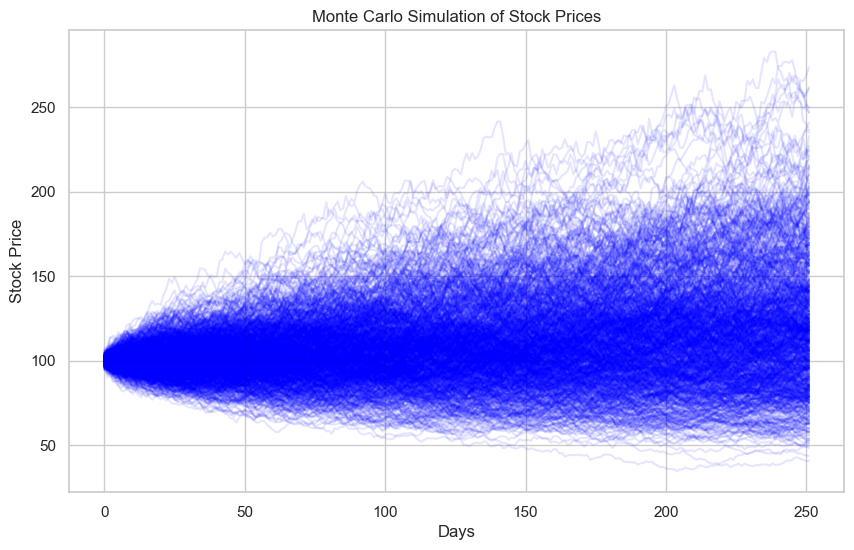

Mean Final Stock Price: $119.13
5th Percentile Final Stock Price: $67.46
95th Percentile Final Stock Price: $190.07


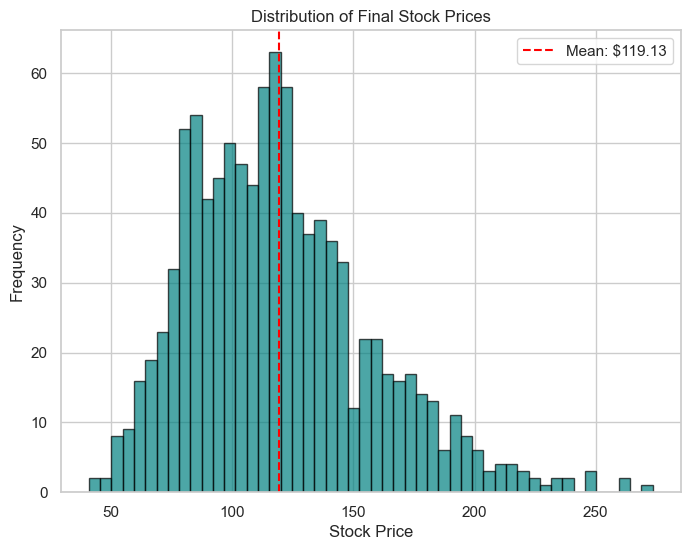

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the simulation
initial_price = 100  # Starting price of the stock
mean_return = 0.0005  # Average daily return (0.05%)
volatility = 0.02  # Daily volatility (2%)
num_days = 252  # Number of trading days in a year
num_simulations = 1000  # Number of simulations

# Simulate multiple paths for the stock price
np.random.seed(42)  # For reproducibility
simulated_prices = np.zeros((num_simulations, num_days))
for i in range(num_simulations):
    daily_returns = np.random.normal(loc=mean_return, scale=volatility, size=num_days)
    simulated_prices[i] = initial_price * np.exp(np.cumsum(daily_returns))

# Plotting the simulations
plt.figure(figsize=(10, 6))
plt.plot(simulated_prices.T, color='blue', alpha=0.1)  # 1000 simulations
plt.title("Monte Carlo Simulation of Stock Prices")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.show()

# Calculating and showing the range of final stock prices
final_prices = simulated_prices[:, -1]
mean_final_price = np.mean(final_prices)
percentile_5th = np.percentile(final_prices, 5)
percentile_95th = np.percentile(final_prices, 95)

print(f"Mean Final Stock Price: ${mean_final_price:.2f}")
print(f"5th Percentile Final Stock Price: ${percentile_5th:.2f}")
print(f"95th Percentile Final Stock Price: ${percentile_95th:.2f}")

# Observing the distribution of final prices
plt.figure(figsize=(8, 6))
plt.hist(final_prices, bins=50, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(mean_final_price, color='red', linestyle='--', label=f"Mean: ${mean_final_price:.2f}")
plt.title("Distribution of Final Stock Prices")
plt.xlabel("Stock Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

**Explanations and Takeaways:** <br>
- **Simulation Setup:** We simulate 1,000 different stock price paths over 252 trading days (roughly a year) with a starting price of $100, an average daily return of 0.05%, and daily volatility of 2%.
- **Monte Carlo Simulation:** We use a random walk model where daily returns are sampled from a normal distribution with the given mean and volatility. The stock price path for each simulation is calculated by applying these daily returns cumulatively to the initial price.
- **Visualization:** The first plot shows the 1,000 simulated stock price paths, giving us a sense of the variability in stock price movements over the course of the year. The second plot shows the distribution of final stock prices, highlighting the likelihood of different outcomes.
- **Key Metrics:** We compute the mean, 5th percentile, and 95th percentile of the final stock prices to quantify the range of potential outcomes. This gives us insight into the likely final stock price, as well as the potential for extreme outcomes (both gains and losses).

**Illustration of Specific Benefits:** <br>
- Range of Possible Outcomes: The simulation provides a range of potential final stock prices, showing how the price could vary over time.
- Likelihood of Outcomes: The histograms and percentiles give insight into the probability of certain price outcomes, helping us understand what could happen under different conditions.

**Illustration of Specific Limitations:** <br>
- Underestimating Extreme Events: While the model provides a good estimate for most scenarios, extreme events (such as large market crashes) may be underrepresented. In reality, the probability of such events might be higher than what is captured by the normal distribution used for daily returns. This is an example of the limitation mentioned earlier: "probability of extreme events is often underestimated" *(Weber, n.d.)*.

### 6. Monte Carlo Process

Monte Carlo simulations rely on a systematic process of using randomness to estimate complex outcomes. Rather than providing a single deterministic answer, the Monte Carlo process generates a range of possible results by repeatedly sampling from probability distributions and analyzing the outcomes statistically. This method is especially useful when analytical solutions are difficult or impossible to derive.

As outlined in Izzy Weber’s Monte Carlo Simulations course on DataCamp *(Weber, n.d.)*, the method follows a structured **four-step process:**

1. **Define Input Variables and Distributions** <br>
Identify the uncertain variables in your model and assign appropriate probability distributions to describe their variability.

2. **Generate Random Inputs** <br>
Sample values randomly from these distributions to represent potential real-world scenarios.

3. **Perform Deterministic Calculations** <br>
Use the sampled inputs in your model to compute outcomes. Each simulation run uses a new set of inputs but follows the same calculation logic.

4. **Summarize and Interpret Results** <br>
After many iterations, aggregate the outcomes to analyze trends, such as average values, confidence intervals, or risk levels. Visualizations such as histograms or box plots can help communicate the results effectively.

This process is also described in Module 1, Lecture 6: "Some Baby Examples" of the class lectures, taught by Professor David Goldsman. While that lesson uses the dartboard method to estimate the value of π, we’ll illustrate the process using a different real-world-inspired example for variety.​

#### Example: Pizza Time

To understand how the Monte Carlo method works, let’s walk through a simple and relatable example: **estimating pizza delivery times**. This scenario, inspired by my own experience in the hospitality industry, shows how probabilistic thinking can help improve operations by accounting for uncertainty in daily processes.

The Monte Carlo process steps *(Weber, n.d.; Goldsman, 2024)*:

1. **Define input variables and assign probability distributions**  
   Identify the factors that influence delivery time:
   - Base preparation time: fixed at 10 minutes
   - Traffic delay: normally distributed with a mean of 15 minutes and standard deviation of 5 minutes
   - Weather impact: adds 5 extra minutes on bad-weather days, which occur 30% of the time (modeled as a binary variable)

2. **Generate random inputs**  
   Simulate thousands of delivery scenarios by sampling:
   - A traffic delay from the normal distribution
   - A weather condition using a random binary outcome (bad or not)

3. **Perform deterministic calculation**  
   For each simulation, compute total delivery time using: Total Time = Base Time + Traffic Delay + Weather Delay

4. **Summarize results**  
After many trials (e.g., 10,000), analyze the distribution of outcomes to determine:
- Average delivery time
- 95% confidence interval
- Probability of delivering within 30 minutes

This approach gives a practical view of variability and helps businesses manage customer expectations more effectively — a key priority in hospitality settings.

**Disclaimer**: The data used in this demonstration is AI-generated and does not represent real-world scenarios. It was created using random sampling techniques and Monte Carlo simulations *(OpenAI, 2025)*.

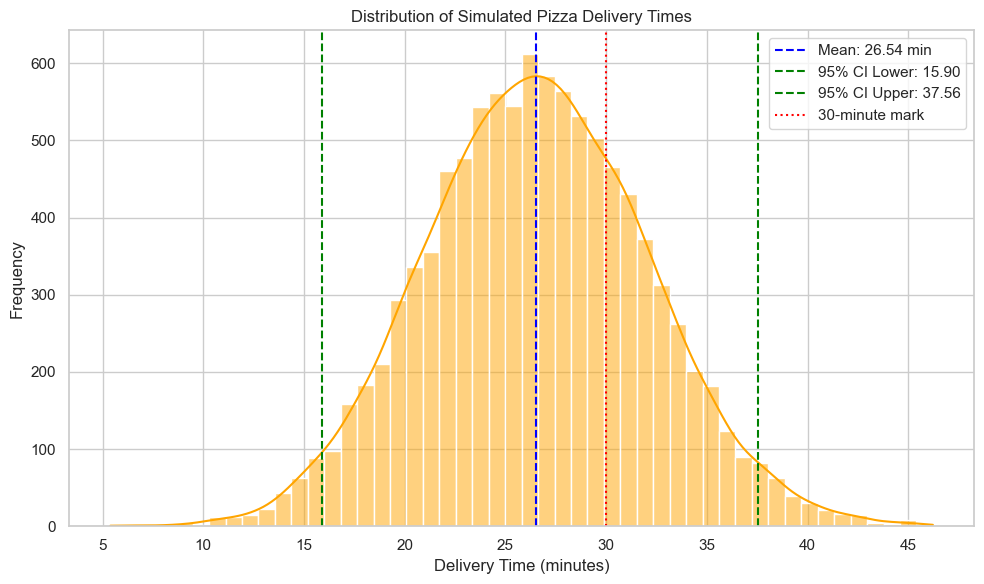

(None, 26.53982008315787, array([15.89696388, 37.55864094]), 0.7336)

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
n_simulations = 10000
base_time = 10  # minutes
traffic_mean = 15
traffic_std = 5
weather_delay = 5
bad_weather_probability = 0.3

# Generate random samples
traffic_delays = np.random.normal(loc=traffic_mean, scale=traffic_std, size=n_simulations)
weather_conditions = np.random.binomial(n=1, p=bad_weather_probability, size=n_simulations)
weather_delays = weather_conditions * weather_delay

# Total delivery times
total_delivery_times = base_time + traffic_delays + weather_delays

# Summary statistics
mean_time = np.mean(total_delivery_times)
ci_95 = np.percentile(total_delivery_times, [2.5, 97.5])
prob_within_30_min = np.mean(total_delivery_times <= 30)

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(total_delivery_times, kde=True, bins=50, color="orange")
plt.axvline(mean_time, color='blue', linestyle='--', label=f'Mean: {mean_time:.2f} min')
plt.axvline(ci_95[0], color='green', linestyle='--', label=f'95% CI Lower: {ci_95[0]:.2f}')
plt.axvline(ci_95[1], color='green', linestyle='--', label=f'95% CI Upper: {ci_95[1]:.2f}')
plt.axvline(30, color='red', linestyle=':', label='30-minute mark')
plt.title("Distribution of Simulated Pizza Delivery Times")
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show(), mean_time, ci_95, prob_within_30_min

**Simulation results:**
- Mean delivery time: approximately 26.54 minutes
- 95% Confidence Interval: between 15.90 and 37.56 minutes
- Probability of delivery within 30 minutes: 73.4%

**Takeaways:** <br>
- The histogram of delivery times likely shows slight right skewness, suggesting that while most deliveries fall within a reasonable timeframe, a few outliers take significantly longer (e.g., due to traffic, weather, or order complexity). This insight is crucial for **identifying bottlenecks** or **worst-case scenarios**.
- Since about 26.6% of deliveries exceed the 30-minute mark, the simulation highlights a potential **customer satisfaction risk** if 30 minutes is the promised delivery time. Businesses can use this information to:
    - Adjust staffing during peak hours
    - Improve route optimization
    - Re-evaluate the feasibility of 30-minute guarantees
- By analyzing the extremes, such as 90th or 95th percentile delivery times, decision-makers can assess the **worst-case scenarios**. For instance, if the 95th percentile delivery time is close to 40 minutes, contingency planning might be needed for high-volume or high-risk days.
- The spread in the results underscores how **small changes in input assumptions** (like prep time or travel time variability) significantly affect the outcomes. This suggests the system is sensitive to operational delays, and further simulation could help prioritize which input to optimize.

The graph below helps illustrate those possible worst-case scenarios:

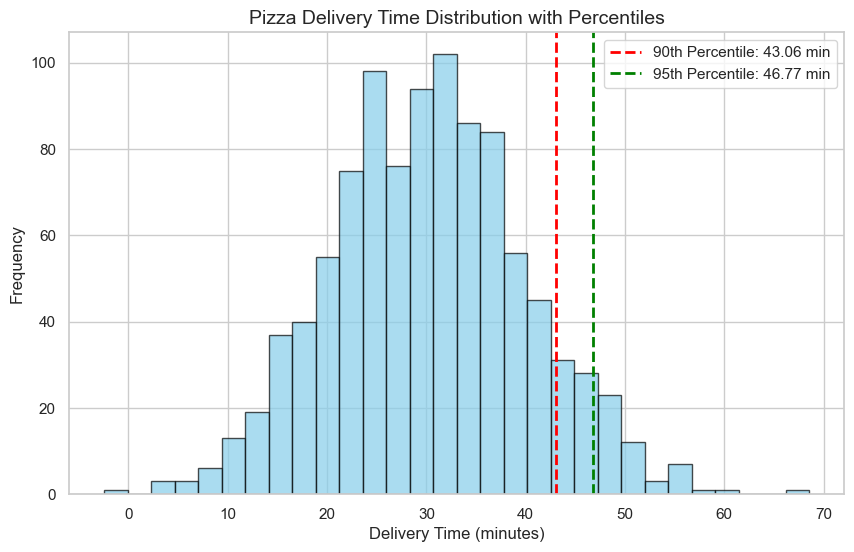

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(42)  # For reproducibility

# Simulate the pizza delivery times using normal distribution
delivery_times = np.random.normal(loc=30, scale=10, size=1000)  # Mean = 30 minutes, StdDev = 10 minutes

# Percentiles
p90 = np.percentile(delivery_times, 90)
p95 = np.percentile(delivery_times, 95)

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(delivery_times, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Highlight the 90th and 95th percentiles
plt.axvline(p90, color='red', linestyle='dashed', linewidth=2, label=f'90th Percentile: {p90:.2f} min')
plt.axvline(p95, color='green', linestyle='dashed', linewidth=2, label=f'95th Percentile: {p95:.2f} min')

# Add labels and title
plt.title("Pizza Delivery Time Distribution with Percentiles", fontsize=14)
plt.xlabel("Delivery Time (minutes)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()

# Show plot
plt.grid(True)
plt.show()

Our Pizza delivery example utilizes the normal, **Gaussian**, distribution.It assumes that most deliveries happen close to the average time, with fewer deliveries happening much faster or much slower, creating the classic bell curve shape. It's a reasonable first assumption for modeling continuous variables like delivery time.
It's **defined by two parameters:** 
- Mean (μ) — the average delivery time (e.g. 30 minutes).
- Standard deviation (σ) — how much the delivery times typically vary from the mean (e.g. ±5 minutes).

Choosing the wrong distribution can seriously affect the reliability of a Monte Carlo simulation.

#### Why Distribution Choice Matters:
Monte Carlo simulations rely on sampling input values based on assumed probability distributions. If the underlying data doesn't actually follow that distribution, the simulation results can be misleading, where we can underestimate or overestimate the resulting probabilities. A simulation is only as good as the assumptions behind it. If you don't have real-world data to guide distribution choice, it’s better to try multiple plausible distributions and compare outcomes. This method is called **sensitivity analysis**.

In *The Model Thinker*, Scott E. Page doesn’t dedicate a standalone chapter to sensitivity analysis, but the concept is deeply embedded throughout the book—especially within his advocacy for the many-model paradigm. This framework encourages the use of multiple models to understand complex systems from different angles. A **key insight** of this approach is that **small changes in model assumptions or input parameters can lead to dramatically different outcomes**. In other words, understanding how sensitive a model is to its assumptions is critical to drawing robust conclusions from it *(Page, 2018)*.

This principle is especially important in public policy or healthcare contexts, like the opioid crisis, where model-driven decisions can affect millions of lives. In the analysis below, we use sensitivity analysis to probe how different assumptions impact simulation outcomes and policy implications. 

#### Example: Modeling Opioid Crisis

Page's book explores how we can use modeling to better understand the opioid crisis. Two key models are discussed: the Multi-Armed Bandit (MAB) and the Markov Model, both of which offer insight into the uncertainty and long-term impacts of public health decisions.

**Multi-Armed Bandit: Drug Approval** <br>
The MAB model helps simulate decision-making under uncertainty, for example, how a health agency might allocate trials across competing drugs. Each "arm" is a different drug, and the challenge is balancing exploration (testing new drugs) with exploitation (investing in drugs already known to work).

In trials, opioids were tested against placebos. The opioid and placebo are treated as two "arms." After treatment, outcomes are measured as success or failure. Early trial results showed that opioids reduced pain significantly in patients undergoing surgeries or cancer treatments, with less than 1% becoming addicted. Based on this, approval was granted.

The MAB model also illustrates how uncertainty and imperfect data can lead to suboptimal or harmful decisions, even with good intentions.

**Markov Model: Addiction Transitions** <br>
This model describes how people move between three states: not in pain, using opioids, and addicted. Transitions between these states are probabilistic, not deterministic. This makes the model well-suited to Monte Carlo simulation, where we simulate many possible futures to estimate long-term outcomes *(Page, 2018, pp. 339-343)*.


**Model A (Optimistic Scenario)**
- 1% of users become addicted
- 10% of addicts recover
- 20% of healthy individuals start using opioids → Long-run: ~2.2% addiction rate

**Model B (Pessimistic Scenario)**
- 2.5% of users become addicted
- 5% of addicts recover
- 20% start using opioids → Long-run: ~10% addiction rate

These small changes in assumptions lead to very different outcomes.


**Sensitivity Analysis** <br>
To assess the robustness of our conclusions, we can vary key transition probabilities and observe how addiction rates respond.

This helps identify:
- Which inputs have the largest effect on outcomes
- Where uncertainty in data is most impactful
- Thresholds beyond which outcomes change dramatically

For example:
- What happens if the addiction rate increases from 1% to 3%?
- What if recovery rates fall due to lack of treatment access?

By running simulations with different assumptions, we reveal the fragility or resilience of our conclusions and provide more informed policy insights.

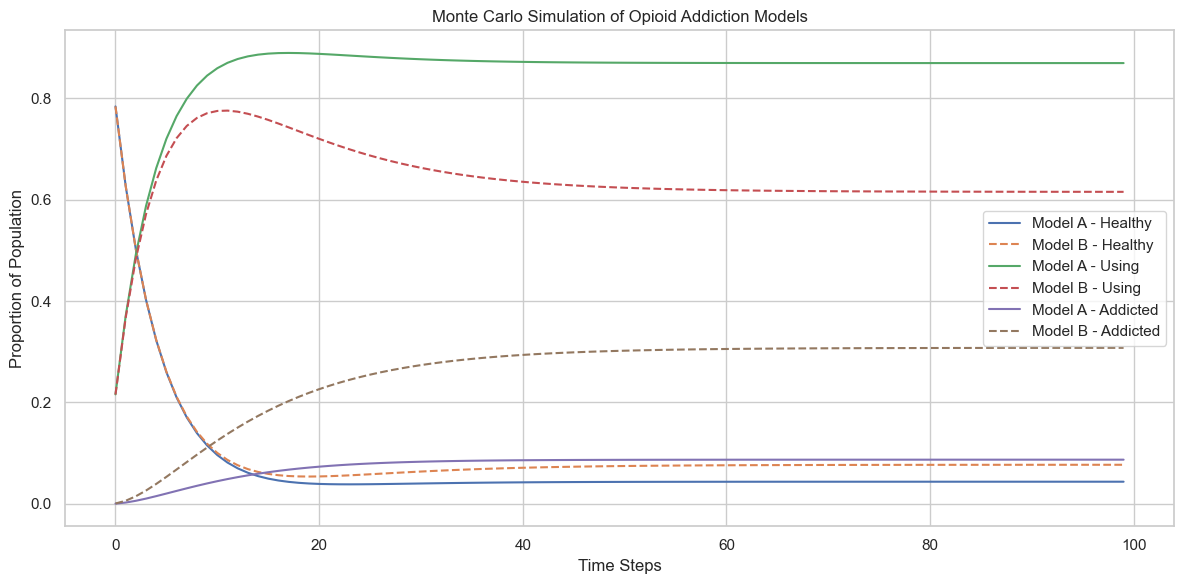

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Define states
states = ["Healthy", "Using", "Addicted"]
state_index = {"Healthy": 0, "Using": 1, "Addicted": 2}

# Define transition matrices for Model A and Model B
transition_matrix_A = np.array([
    [0.80, 0.20, 0.00],  # Healthy
    [0.00, 0.99, 0.01],  # Using
    [0.10, 0.00, 0.90]   # Addicted
])

transition_matrix_B = np.array([
    [0.80, 0.20, 0.00],  # Healthy
    [0.00, 0.975, 0.025],# Using
    [0.05, 0.00, 0.95]   # Addicted
])

# Monte Carlo Simulation Parameters
n_steps = 100
n_simulations = 1000
initial_state = np.array([0.98, 0.02, 0.00])  # Start: 98% Healthy, 2% Using, 0% Addicted

def run_simulation(matrix, n_steps, initial_state):
    trajectory = np.zeros((n_steps, 3))
    state = initial_state.copy()
    for t in range(n_steps):
        state = np.dot(state, matrix)
        trajectory[t] = state
    return trajectory

# Run simulations and average the results
trajectories_A = np.zeros((n_steps, 3))
trajectories_B = np.zeros((n_steps, 3))

for _ in range(n_simulations):
    trajectories_A += run_simulation(transition_matrix_A, n_steps, initial_state)
    trajectories_B += run_simulation(transition_matrix_B, n_steps, initial_state)

trajectories_A /= n_simulations
trajectories_B /= n_simulations

# Plot the results
plt.figure(figsize=(12, 6))

for i, label in enumerate(states):
    plt.plot(trajectories_A[:, i], label=f"Model A - {label}")
    plt.plot(trajectories_B[:, i], linestyle="--", label=f"Model B - {label}")

plt.title("Monte Carlo Simulation of Opioid Addiction Models")
plt.xlabel("Time Steps")
plt.ylabel("Proportion of Population")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

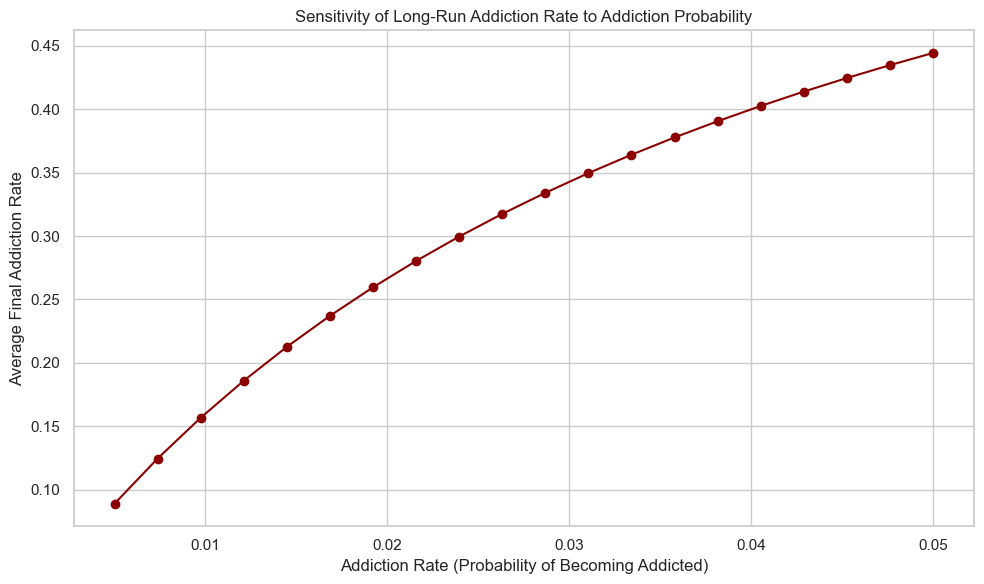

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation settings
n_steps = 1000
n_simulations = 100
population = 10000

# Sensitivity range for addiction_rate
addiction_rates = np.linspace(0.005, 0.05, 20)
avg_addicted = []

# Fixed values for other parameters
recovery_rate = 0.05
initiation_rate = 0.20

for addiction_rate in addiction_rates:
    addicted_counts = []

    for _ in range(n_simulations):
        state = np.zeros((n_steps, 3))
        state[0] = [population, 0, 0]  # [no_pain, using, addicted]

        for t in range(1, n_steps):
            no_pain, using, addicted = state[t - 1]

            new_using = initiation_rate * no_pain
            new_addicted = addiction_rate * using
            recovered = recovery_rate * addicted

            no_pain = no_pain - new_using + recovered
            using = using + new_using - new_addicted
            addicted = addicted + new_addicted - recovered

            state[t] = [no_pain, using, addicted]

        addicted_counts.append(state[-1, 2])

    avg_addicted.append(np.mean(addicted_counts) / population)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(addiction_rates, avg_addicted, marker='o', color='darkred')
plt.title("Sensitivity of Long-Run Addiction Rate to Addiction Probability")
plt.xlabel("Addiction Rate (Probability of Becoming Addicted)")
plt.ylabel("Average Final Addiction Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

The chart above shows a **sensitivity analysis** of how the final addiction rate responds to changes in the addiction probability (while keeping recovery and initiation rates fixed).

**Key takeaways:**
- Even small increases in the probability of addiction can significantly raise the long-term percentage of addicted individuals in the population.
- This illustrates **how sensitive the system is to initial assumptions**, reinforcing the value of Monte Carlo methods and scenario testing when modeling public health outcomes.

### 7. Sampling from different distributions

As we’ve seen, real-world processes often involve uncertainty — and instead of using fixed values, we can sample inputs from probability distributions to reflect this variability more accurately.

This approach is emphasized in both Monte Carlo simulations and the many-model thinking strategy discussed by Page (2018, pp.339-343). It's also covered in the DataCamp course by Izzy Weber, where several distributions are introduced for use in simulations.

So far, we’ve worked mostly with fixed transition probabilities in our Markov and Monte Carlo models. But what if those probabilities aren’t fixed? What if they vary across populations or depend on external factors like policy changes, demographics, or socioeconomic status?

To reflect this uncertainty more realistically, we can sample input parameters (like addiction or recovery rates) from different probability distributions.

**Why Sample from Distributions?**
- Real-world variability: Parameters often aren't known with certainty. Distributions let us capture a range of plausible values.
- Robust predictions: Sampling allows us to model many possible futures rather than one fixed scenario.
- Uncertainty quantification: We can quantify how much variation in inputs affects outcomes (e.g., addiction rates, delivery time, financial forecasts).

#### Example: Monte Carlo with Sampled Transition Rates
In this example, each simulation will sample transition probabilities from Beta distributions, which are well-suited for modeling probabilities such as the likelihood of addiction, recovery, and starting opioids.

The Beta distribution is defined by two parameters:  
`Beta(α, β)`  
where:  
- **α ("alpha")** = the number of prior "successes" (e.g., people starting opioids)  
- **β ("beta")** = the number of prior "failures" (e.g., people not starting opioids)

These parameters reflect prior knowledge or confidence in the probability estimate.

For our model, we use the following Beta distributions:
- **No pain → Opioid user**: `Beta(10, 40)` represents a belief where we've observed 10 successes (people starting opioids) and 40 failures (those who did not).
- **Opioid user → Addicted**: `Beta(3, 115)` reflects the probability of transitioning from opioid use to addiction.
- **Addicted → Recovered**: `Beta(5, 95)` models the likelihood of an addicted person recovering.

We will run the simulation 1,000 times, recording the addiction rate after 20 timesteps in each run.


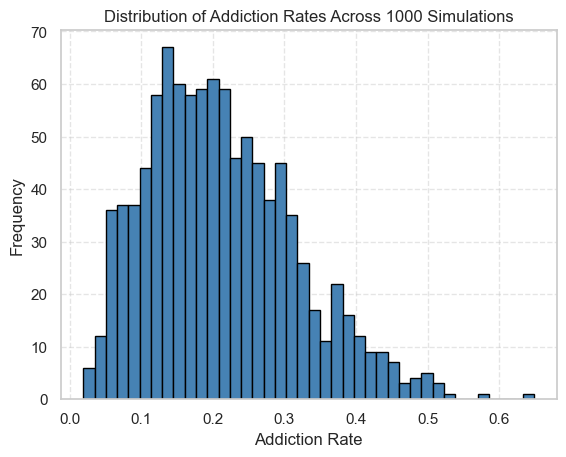

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
runs = 1000
population = 100000
timesteps = 20
results = []

np.random.seed(42)  # For reproducibility

for _ in range(runs):
    # Sample transition rates from beta distributions
    p_start_opioid = np.random.beta(10, 40)
    p_user_addict = np.random.beta(3, 115)
    p_addict_recover = np.random.beta(5, 95)

    # Initial states
    no_pain = np.ones(population, dtype=bool)
    opioid_user = np.zeros(population, dtype=bool)
    addicted = np.zeros(population, dtype=bool)

    # Time simulation
    for _ in range(timesteps):
        # No pain → opioid user
        new_users = (np.random.rand(population) < p_start_opioid) & no_pain
        no_pain[new_users] = False
        opioid_user[new_users] = True

        # Opioid user → addicted
        new_addicts = (np.random.rand(population) < p_user_addict) & opioid_user
        opioid_user[new_addicts] = False
        addicted[new_addicts] = True

        # Addicted → recovered
        recovered = (np.random.rand(population) < p_addict_recover) & addicted
        addicted[recovered] = False
        no_pain[recovered] = True

    # Store final addiction rate
    addiction_rate = addicted.sum() / population
    results.append(addiction_rate)

# Plot results
plt.hist(results, bins=40, color='steelblue', edgecolor='black')
plt.title('Distribution of Addiction Rates Across 1000 Simulations')
plt.xlabel('Addiction Rate')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Key takeaways:** <br>

This graph above helps us understand the range and likelihood of different addiction rates, providing insight into the uncertainty and variability in the model's predictions.

- **Distribution Shape:** The distribution is more concentrated on the left, with a longer tail on the right. This suggests that the majority of simulations result in lower addiction rates, but there are a few simulations with significantly higher rates. This variability points to the uncertainty inherent in the system — small changes in the transition probabilities (such as the probability of starting opioids or becoming addicted) can lead to significantly different addiction rates.

- **Most Common Addiction Rate:** The most common addiction rate is approximately around 0.14, indicating the mode of the distribution. This suggests that under the current assumptions, the addiction rate is likely to fall around this value, but there is considerable uncertainty in this estimate due to the random nature of the model and variability in transition rates.

- **Spread of Results:** The addiction rates range from 0 to 0.55, with a few outliers present around 0.58 and 0.65. The presence of these outliers highlights the sensitivity of the model to certain parameters — small changes in the transition probabilities can lead to large shifts in the final addiction rates. This indicates that the model is sensitive to specific factors, such as the probability of addiction and recovery.

- **Central Tendency:** The central tendency of the addiction rates appears to be between 0.1 and 0.2, meaning that most simulation runs fall within this range. However, the spread and outliers suggest that this value should be treated with uncertainty, as real-world variations in opioid use and addiction could lead to different outcomes.

In summary, while the most common addiction rate lies between 0.1 and 0.2, the wide spread of results and the presence of outliers indicate **significant uncertainty and sensitivity in the model's predictions**. Small changes in the assumptions (like addiction or recovery rates) can result in large differences in outcomes, underscoring the importance of understanding and managing uncertainty in public health modeling.

#### But what if we sampled from the wrong distribution?
Let’s say we use a uniform distribution to model the probability of an opioid user becoming addicted, instead of the beta distribution.

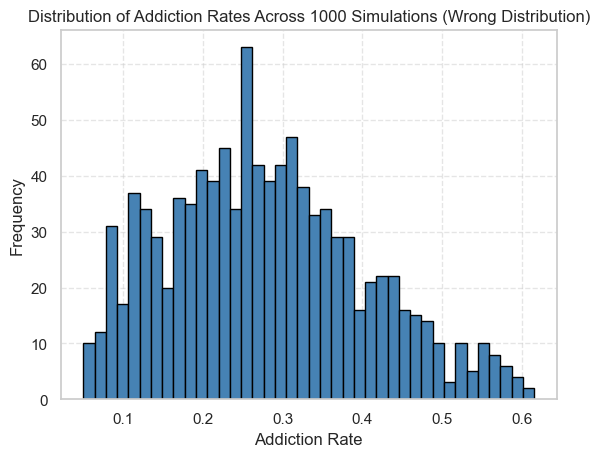

In [50]:
# Parameters
runs = 1000
population = 100000
timesteps = 20
results = []

np.random.seed(42)

for _ in range(runs):
    # Sample transition rates from uniform distributions instead of beta distributions
    p_start_opioid = np.random.uniform(0.1, 0.3)  # Uniform distribution for starting opioids
    p_user_addict = np.random.uniform(0.01, 0.1)  # Uniform distribution for becoming addicted
    p_addict_recover = np.random.uniform(0.03, 0.15)  # Uniform distribution for recovery

    # Initial states
    no_pain = np.ones(population, dtype=bool)
    opioid_user = np.zeros(population, dtype=bool)
    addicted = np.zeros(population, dtype=bool)

    # Time simulation
    for _ in range(timesteps):
        # No pain → opioid user
        new_users = (np.random.rand(population) < p_start_opioid) & no_pain
        no_pain[new_users] = False
        opioid_user[new_users] = True

        # Opioid user → addicted
        new_addicts = (np.random.rand(population) < p_user_addict) & opioid_user
        opioid_user[new_addicts] = False
        addicted[new_addicts] = True

        # Addicted → recovered
        recovered = (np.random.rand(population) < p_addict_recover) & addicted
        addicted[recovered] = False
        no_pain[recovered] = True

    # Store final addiction rate
    addiction_rate = addicted.sum() / population
    results.append(addiction_rate)

# Plot results
plt.hist(results, bins=40, color='steelblue', edgecolor='black')
plt.title('Distribution of Addiction Rates Across 1000 Simulations (Wrong Distribution)')
plt.xlabel('Addiction Rate')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### Consequences of Using a Uniform Distribution here:
- **Reduced Variability:** By sampling from a uniform distribution, we artificially constrain the probabilities within fixed ranges (e.g., 0.1 to 0.3 for starting opioids), which means we will get a more "flattened" distribution of addiction rates.
- **Unrealistic Central Tendency:** The results will likely show a narrower range of addiction rates and may fail to represent extreme cases accurately. We won't capture the true risk distribution if the real-world process is more prone to skewed outcomes.
- **Distorted Sensitivity and Uncertainty:** The model would falsely imply that there is less variability in addiction rates than there actually is, leading to a distorted view of the uncertainty in predicting addiction rates.

#### Key takeaways:
The choice of distribution plays a significant role in modeling. Sampling from an inappropriate distribution (like the uniform distribution in this example) can lead to unrealistic results, diminishing the reliability of the model’s insights. Understanding and selecting the right distribution (like the beta distribution) ensures the model captures the true dynamics of the system, allowing for better predictions and more accurate risk assessments.

### 8. Markov Chain Monte Carlo (MCMC)

**Bayesian networks** offer a powerful and flexible framework for probabilistic modeling. They can be viewed as generative models, recipes for probabilistically constructing states of the world. For instance, in a simple burglary-alarm scenario, we first determine whether a burglary or earthquake occurred, then whether the alarm sounds, and finally whether neighbors call the police. This **stepwise generation** process captures **conditional dependencies** between variables, forming the **backbone of the Bayesian network structure** *(Domingos, 2015)*.

Many familiar models are special cases of Bayesian networks. Naive Bayes assumes feature independence given the class label. Markov Chains extend this by encoding the **assumption that the future is conditionally independent of the past given the present**. Hidden Markov Models (HMMs) further assume that each observation is dependent only on the current hidden state. These simplifications allow for tractable inference, but the general Bayesian network provides the expressive power to model complex interactions

This expressiveness is particularly valuable in fields like genomics, where diseases often result from intricate interactions among many genes and environmental variables. Rather than relying solely on pairwise correlations, Bayesian networks can reveal deeper relationships. A striking example of this is in HIV vaccine research, where David Heckerman and his colleagues used Bayesian networks to identify stable, vulnerable regions in the virus’s protein structure—regions that couldn’t mutate without compromising the virus’s viability. By focusing on these weak links, much like spam filters do with fixed URLs, they developed targeted vaccine strategies that are now entering clinical trials *(Domingos, 2015)*.

Despite their power, Bayesian networks pose a significant computational challenge: **how do we efficiently compute or sample from the complex joint distribution** they represent? This is where Markov Chain Monte Carlo (MCMC) comes in.

MCMC methods **simulate a random walk** through the space of possible variable configurations in a way that, over time, visits states in proportion to their true probability. If the Markov Chain is well-designed, it converges to the target distribution. A common MCMC approach is Gibbs sampling, which cycles through each variable, sampling from its conditional distribution given its neighbors, a method reminiscent of the **network propagation** concepts discussed by Page(2018, pp.121-126).

The origins of MCMC date back to the **Manhattan Project**, where it was used to simulate **nuclear chain reactions**. Today, MCMC is invaluable not only for computing probabilities but for **approximating integrals in complex models** where analytical solutions are intractable *(Goldsman, 2024, Module 3, Lecture Notes 2 and 3)*. It’s one of the key reasons Bayesian methods have become so widely adopted in modern data science.

However, MCMC is not without pitfalls. It **can be slow to converge**, and **deceptive** in appearing to have stabilized when it hasn’t. Real-world distributions are often rugged, with sharp peaks and vast low-probability regions. Without careful design and diagnostics, MCMC chains may get stuck in local modes, yielding biased results.

#### Example: Markov Chains and Opioid Addiction
In the opioid crisis example drawn from *The Model Thinker* (Page, 2018, pp. 339–343), we assumed known transition probabilities between behavioral states, often informed by distributions like Beta. But what if we only had partial or noisy data, such as how many individuals developed addiction or entered recovery?

This is where Markov Chain Monte Carlo (MCMC) becomes powerful:

**MCMC allows us to:**
- Infer unknown parameters (e.g., transition rates) from observed data.
- Quantify the uncertainty around those estimates.
- Generate a posterior distribution of outcomes, rather than a single point estimate.

**How it works:**
MCMC works by constructing a **Markov Chain that explores the space of parameters**, using each sample to inform the next. Over time, the chain converges to the **posterior distribution**, enabling probabilistic reasoning about model behavior and parameter estimates.

Let’s consider a simple behavioral **model of addiction**. Each day, an individual is in one of **three states:**
- Sober (S)
- Using (U)
- Recovering (R)

The **likelihood of transitioning** between these states, based on psychological models, public health data, or expert input, is summarized below:

| **From \ To** | **Sober (S)** | **Using (U)** | **Recovering (R)** |
|---------------|---------------|---------------|---------------------|
| **Sober**     | 0.6           | 0.3           | 0.1                 |
| **Using**     | 0.1           | 0.6           | 0.3                 |
| **Recovering**| 0.7           | 0.2           | 0.1                 |

This setup defines a **Markov Chain: the probability of tomorrow’s state depends only on today’s state**, not the full history, a property known as the **Markov assumption** *(Domingos, 2015)*.

Estimated long-term probability of being Sober: 0.424
Estimated long-term probability of being Using: 0.401
Estimated long-term probability of being Recovering: 0.175


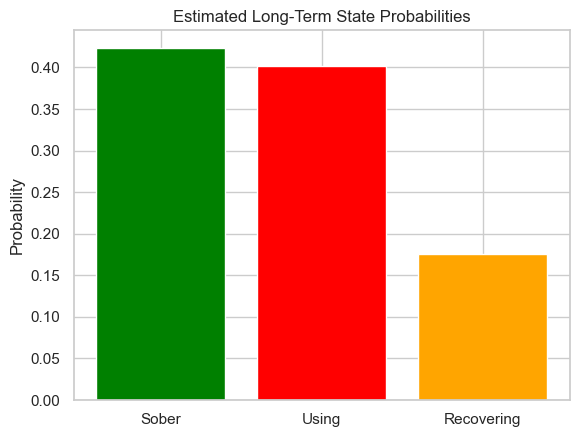

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Define the transition matrix
states = ['Sober', 'Using', 'Recovering']
state_to_index = {state: i for i, state in enumerate(states)}
transition_matrix = np.array([
    [0.6, 0.3, 0.1],  # From Sober
    [0.1, 0.6, 0.3],  # From Using
    [0.7, 0.2, 0.1]   # From Recovering
])

# Simulate the Markov Chain
np.random.seed(42)
n_steps = 10000
current_state = 0  # Start from Sober
counts = np.zeros(len(states))

for _ in range(n_steps):
    counts[current_state] += 1
    current_state = np.random.choice([0, 1, 2], p=transition_matrix[current_state])

# Convert to probabilities
steady_state_probs = counts / n_steps

# Display the results
for i, state in enumerate(states):
    print(f"Estimated long-term probability of being {state}: {steady_state_probs[i]:.3f}")

# Plotting
plt.bar(states, steady_state_probs, color=['green', 'red', 'orange'])
plt.title("Estimated Long-Term State Probabilities")
plt.ylabel("Probability")
plt.show()

**Key takeaways from the graph:** <br>
1. **Steady-State Behavior Emerges:** <br>
After enough time steps, the proportions of people in each state: Sober, Using, and Recovering, begin to stabilize. This shows that the Markov Chain is converging to a stationary distribution, regardless of where it started.

2. **Long-Term State Distribution:** <br>
The graph shows the likelihood of being in each state over the long term. For example, if the "Using" line levels off around 45%, it suggests that about 45% of people tend to remain in that state over time. This kind of insight can help inform targeted interventions.

3. **Effect of Transition Probabilities:** <br>
Some states are more "sticky" than others. For instance, a high probability of staying in the "Using" state makes it harder for individuals to move to recovery. The graph reflects how these probabilities shape long-term behavior.

4. **Recovery and Relapse Patterns:** <br>
If the "Recovering" state rises and then flattens or declines, it may indicate common relapse patterns. The simulation reflects the challenges of sustaining recovery and how people might cycle through states.

5. **Initial Conditions Have Less Impact Over Time:** <br>
Even if everyone starts out sober, the system eventually reflects the same long-term proportions. This supports the Markov property: future outcomes depend only on the current state, not how the system started.



#### Modifying the Code for Policy or Scenario Analysis
The simulation code we wrote is flexible and easy to adapt. You can hardcode new transition matrices to represent different interventions, policy changes, or worsening conditions.

Each scenario is defined by a 3x3 transition matrix, where each row represents the probability of moving from one state (Sober, Using, Recovering) to another. By modifying the values in this matrix, we simulate how behavior patterns shift over time under different assumptions.

##### Example Scenarios:
1. **Increased Access to Recovery Programs:** <br>
    - Goal: Help more individuals transition from "Using" to "Recovering."
    - Change: Increase Using → Recovering probability from 0.3 to 0.5.

2. **First-Time Use Prevention Campaign:** <br>
    - Goal: Prevent those who are sober from starting drug use.
    - Change: Decrease Sober → Using from 0.3 to 0.1.

3. **Relapse Prevention:** <br>
    - Goal: Help individuals in "Recovering" stay sober.
    - Change: Increase Recovering → Sober from 0.7 to 0.85.

4. **Worsening Addiction Crisis:** <br>
    - Goal: Simulate what happens if relapse and addiction rates rise.
    - Change: Increase Sober → Using and Recovering → Using to 0.4.

##### How to Implement:

1. Choose a scenario and simply update the transition matrix in the code.
2. Rerun the simulation and observe how the long-run state distribution changes.
3. Plotting the results helps visualize the impact of each intervention over time.


#### Absorbing States:

Before we move on to handling uncertainty in our transition probabilities, it’s important to explore a scenario where a state is **irreversible**: once entered, the system cannot leave. These types of states are known as absorbing states.

In many real-world systems, especially when modeling phenomena like disease progression, addiction, or financial ruin, certain outcomes are permanent. For example, once someone reaches a state like "Deceased" in our opioid addiction model, they can’t transition out. This concept is vital for understanding how Markov Chains behave over time, and it introduces an important layer of complexity to our models.

Absorbing states play a key role in the long-term behavior of Markov Chains. A Markov Chain with absorbing states has certain states that, once entered, cannot be left, and the system remains in these states forever *(Feller, 1968, pp. 384-390)*.

Let’s now explore how absorbing states impact the dynamics of our system.

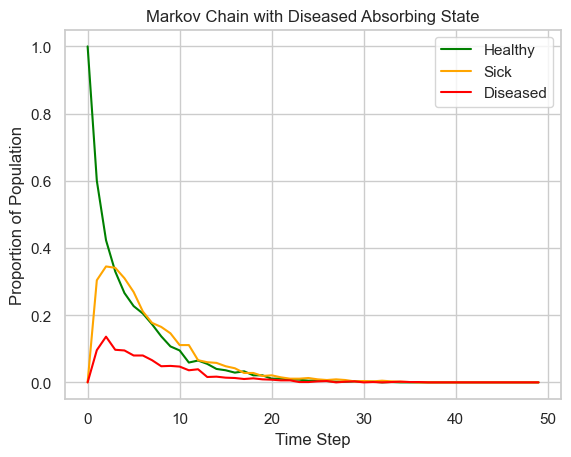

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
population = 1000
timesteps = 50
absorbing_state = 'Diseased'

# Transition matrix with absorbing state (Diseased)
# States: 0 - "Healthy", 1 - "Sick", 2 - "Diseased"
transition_matrix = np.array([[0.6, 0.3, 0.1],  # From Healthy
                              [0.2, 0.6, 0.2],  # From Sick
                              [0.0, 0.0, 1.0]])  # Diseased state is absorbing

# Simulating the Markov Chain
states = ['Healthy', 'Sick', 'Diseased']
state_counts = np.zeros((timesteps, len(states)))

# Simulating each individual in the population
for i in range(population):
    state = 0  # Start from Healthy
    for t in range(timesteps):
        state_counts[t, state] += 1
        if state == 2:  # Diseased state is terminal
            break
        # Transition to the next state
        state = np.random.choice([0, 1, 2], p=transition_matrix[state])

# Calculate the proportion of people in each state over time
healthy_proportion = state_counts[:, 0] / population
sick_proportion = state_counts[:, 1] / population
diseased_proportion = state_counts[:, 2] / population

# Plot the results
plt.plot(range(timesteps), healthy_proportion, label='Healthy', color='green')
plt.plot(range(timesteps), sick_proportion, label='Sick', color='orange')
plt.plot(range(timesteps), diseased_proportion, label='Diseased', color='red')
plt.xlabel('Time Step')
plt.ylabel('Proportion of Population')
plt.title('Markov Chain with Diseased Absorbing State')
plt.legend()
plt.grid(True)
plt.show()

**Explanation:**
- Healthy: 60% chance stays Healthy, 30% chance becomes Sick, 10% chance becomes Diseased
- Sick: 20% chance becomes Healthy, 60% chance stays Sick, 20% chance becomes Diseased
- Diseased: Once entered, stays Diseased (probabilities are 0)

As time progresses, the proportion of Diseased individuals increases, while the proportions of Healthy and Sick decrease. In this scenario, Diseased is an absorbing state, and once the system enters it, no further transitions are possible. Absorbing states change the dynamics by **adding a finality to the system**. They prevent any further movement once entered, thereby altering the long-term behavior, stability, and final state distributions of the system. Understanding how quickly the system absorbs and what the eventual population composition looks like (i.e. how many people are in the absorbing state vs. others) is a crucial element of these models.

Understanding such boundary conditions sets the stage for exploring how uncertainty in our transition probabilities can affect the system's dynamics.

#### Uncertainty in Transition Matrix
Uncertainty in the transition matrix can arise in real-world scenarios where we don't have exact knowledge of the probabilities, for instance, when predicting the likelihood of someone transitioning from "sober" to "using" in the addiction model. This is where techniques like MC Dropout come into play. **MC Dropout**, commonly used in deep learning, enables us to **estimate the uncertainty of predictions** by **randomly dropping units** during training. By performing multiple forward passes with dropout active, we can sample from the model’s posterior distribution, giving us a sense of how uncertain our predictions are.

This technique can be applied to Markov Chains to better **capture the inherent uncertainty in our transition probabilities**. By modeling the transition matrix with a probability distribution instead of fixed values, we can propagate uncertainty through the chain, providing a more robust understanding of possible future states.

For more detailed insights into MC Dropout and its application to uncertainty estimation, see *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow* *(Geron, 2019, pp. 368-370)*.

#### Example: Handling Uncertainty with MC Dropout
Here’s an example of how you might implement MC Dropout to handle uncertainty in the transition matrix using a simple deep learning model in Python. We'll simulate an environment similar to Markov Chains but incorporate the dropout technique to introduce uncertainty in the transition probabilities.

In this example, we’ll use a basic neural network with dropout layers to simulate the uncertainty in predicting the transitions between states, and we will perform multiple forward passes to estimate the uncertainty.

In [55]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the neural network model with dropout
def create_model():
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(3,)),  # 3 input states: Sober, Using, Recovering
        layers.Dropout(0.5),  # Dropout layer to introduce uncertainty
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),  # Dropout layer to introduce uncertainty
        layers.Dense(3, activation='softmax')  # Output layer: 3 states (Sober, Using, Recovering)
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Sample transition matrix data: Sober, Using, Recovering
transition_data = np.array([
    [0.6, 0.3, 0.1],  # Transitions from Sober
    [0.1, 0.6, 0.3],  # Transitions from Using
    [0.7, 0.2, 0.1]   # Transitions from Recovering
])

# Define the states: Sober, Using, Recovering
states = np.array([0, 1, 2])

# Create model
model = create_model()

# Train the model (using the transition matrix data as a placeholder)
# In practice, you would train on historical data of transitions
# Here we're using random data to illustrate
X_train = np.random.rand(1000, 3)  # Random input data
y_train = np.random.rand(1000, 3)  # Random target data

# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Perform multiple forward passes with dropout active to simulate uncertainty
def predict_with_uncertainty(model, input_data, num_samples=100):
    predictions = np.zeros((num_samples, 3))
    for i in range(num_samples):
        # Perform a forward pass with dropout
        predictions[i] = model(input_data, training=True).numpy()
    
    # Calculate the mean and uncertainty (standard deviation)
    mean_prediction = predictions.mean(axis=0)
    uncertainty = predictions.std(axis=0)
    return mean_prediction, uncertainty

# Example input: state "Sober" (index 0)
input_data = np.array([[1, 0, 0]])  # Representing the "Sober" state

# Get the predicted transition probabilities and uncertainty
mean_prediction, uncertainty = predict_with_uncertainty(model, input_data)

print("Predicted transition probabilities:", mean_prediction)
print("Uncertainty (standard deviation) in transitions:", uncertainty)


2025-04-21 00:22:28.946749: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3218 - loss: 1.7404
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3320 - loss: 1.7590
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3480 - loss: 1.9408
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3044 - loss: 2.6398
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3612 - loss: 4.0325
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3463 - loss: 6.3066
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3247 - loss: 9.9553
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3151 - loss: 13.8141
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3171 - loss: 19.1662
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3317 - loss: 23.5382
Predicted transition probabilities: [0.34566258 0.38387893 0.27045849]
Uncertainty (standard deviation) in transitions: [0.45727049 0.46685877 0.42481044]


**Code explanation:** <br>
- **Model Structure:** The model uses two dropout layers (with a dropout rate of 50%) to simulate the uncertainty in transition probabilities. Each forward pass will randomly drop units in the network, creating variations in the output.
- **Uncertainty Estimation:** By running multiple forward passes with dropout active (training=True), we simulate the uncertainty of our model’s predictions. The predicted transition probabilities are stored for each pass, and we compute both the mean and the standard deviation (uncertainty) of the predictions.
- **Input:** The input input_data represents the current state (e.g. "Sober"). We use one-hot encoding for simplicity (i.e., [1, 0, 0] for "Sober").
- **Output:** The output shows the mean predicted transition probabilities and the uncertainty (standard deviation) for each state transition.

**Key Takeaway:** <br>
The code example above demonstrates how MC Dropout can be used to handle uncertainty in transition probabilities within a Markov Chain-like model. By simulating multiple predictions with dropout, we estimate both the likely outcomes (mean) and the uncertainty around them, which can be crucial when dealing with noisy or incomplete data.

This approach is especially useful when working with probabilistic models like Markov Chains where transition matrices may be uncertain due to lack of data or inherent variability.

### 9. Advanced Topics in MCMC

As we've explored the foundations of Markov Chains and methods for handling uncertainty in transition matrices, such as Monte Carlo (MC) Dropout, we’re now ready to pivot toward more advanced algorithms that build on these principles. These techniques deepen our understanding of probabilistic modeling and enable us to address more complex, dynamic systems.

In this final chapter, we will explore several of the most powerful tools in modern machine learning and data science. These algorithms are specifically designed to deal with real-world scenarios where data is noisy, incomplete, or highly uncertain. Topics such as **Hidden Markov Models (HMMs)**, **Gibbs Sampling**, Variational Inference, and Reinforcement Learning will be at the core of our exploration.

While traditional Markov Chains are invaluable for **modeling sequential processes**, they often assume **relatively simple** dynamics and full observability. In contrast, many real-world problems involve hidden variables, complex dependencies, or non-linear relationships. In such cases, advanced probabilistic methods are required to capture the underlying structure. These approaches extend the ideas behind Markov Chains to provide greater modeling flexibility, and they are critical in fields such as speech recognition, natural language processing, time series analysis, reinforcement learning, and generative modeling.

#### Hidden Markov Models Overview

Hidden Markov Models (HMMs) extend basic Markov Chains to **handle systems with unobserved (hidden) states**, where we can only observe **noisy or partial signals**. As explained by Bishop in *Pattern Recognition and Machine Learning* (2006, pp. 610–635), HMMs model uncertainty and provide a structured approach for time series and sequential data where the true state is not directly visible.

In this section, we’ll unpack how HMMs work, common challenges they present, and practical solutions, including Gibbs Sampling, a foundational Markov Chain Monte Carlo (MCMC) method for inference in models with latent variables. These tools empower us to make more robust predictions and extract deeper insights across a wide range of applications.

##### How HMMs Work
Unlike traditional Markov Chains, which assume full visibility of the system’s state, HMMs work with situations where **we observe only indirect signals related to hidden states**. To estimate an HMM’s parameters, we use maximum likelihood by marginalizing over the latent variables *(Bishop, 2006, p. 615)*. Efficient inference can be performed with the forward-backward algorithm (**Baum-Welch**) *(Bishop, 2006, p. 618)*, and the **Viterbi algorithm** helps find the most probable sequence of states (Bishop, 2006, p. 629).

#### Example: HMMs in Action
In this example, we’ll programmatically explore the core idea of Hidden Markov Models: uncertainty in hidden states, where the system’s true state is not directly observed. Instead, we only see a sequence of outputs or behaviors that are probabilistically linked to those hidden states.

- The **hidden states** will represent whether a person is *Sober* or *Using*.
- The **observations** be be behaviors like *Alert*, *Tired*, or *Withdrawn*.

These observed behaviors are known as **emissions**, generated by the underlying hidden states. An HMM is **defined by**:

- A transition matrix A that governs the probabilities of moving between hidden states.
- An emission matrix B that links hidden states to observable outputs.
- An initial state distribution π, which defines where the sequence is likely to start.

**Disclaimer:** The data used in this demonstration is synthetically generated and does not reflect real-world scenarios. It was created using probabilistic modeling and Monte Carlo simulation techniques *(OpenAI, 2025)*.

In [57]:
import numpy as np

# States and observations
states = ["Sober", "Using"]
observations = ["Alert", "Tired", "Withdrawn"]

# State index mapping
state_map = {state: i for i, state in enumerate(states)}
obs_map = {obs: i for i, obs in enumerate(observations)}

# Transition probability matrix (A)
A = np.array([
    [0.7, 0.3],  # Sober → [Sober, Using]
    [0.4, 0.6]   # Using → [Sober, Using]
])

# Emission probability matrix (B)
B = np.array([
    [0.6, 0.3, 0.1],  # Sober → [Alert, Tired, Withdrawn]
    [0.1, 0.3, 0.6]   # Using → [Alert, Tired, Withdrawn]
])

# Initial state probabilities
pi = np.array([0.8, 0.2])  # More likely to start sober

# Generate an observation sequence
def generate_sequence(length=10):
    hidden_states = []
    observed_sequence = []

    state = np.random.choice(len(states), p=pi)
    for _ in range(length):
        hidden_states.append(states[state])
        obs = np.random.choice(len(observations), p=B[state])
        observed_sequence.append(observations[obs])
        state = np.random.choice(len(states), p=A[state])

    return hidden_states, observed_sequence

hidden_seq, observed_seq = generate_sequence()
print("Hidden States: ", hidden_seq)
print("Observations:  ", observed_seq)


Hidden States:  ['Sober', 'Sober', 'Sober', 'Sober', 'Sober', 'Using', 'Using', 'Sober', 'Sober', 'Sober']
Observations:   ['Tired', 'Alert', 'Alert', 'Alert', 'Alert', 'Withdrawn', 'Alert', 'Tired', 'Alert', 'Alert']


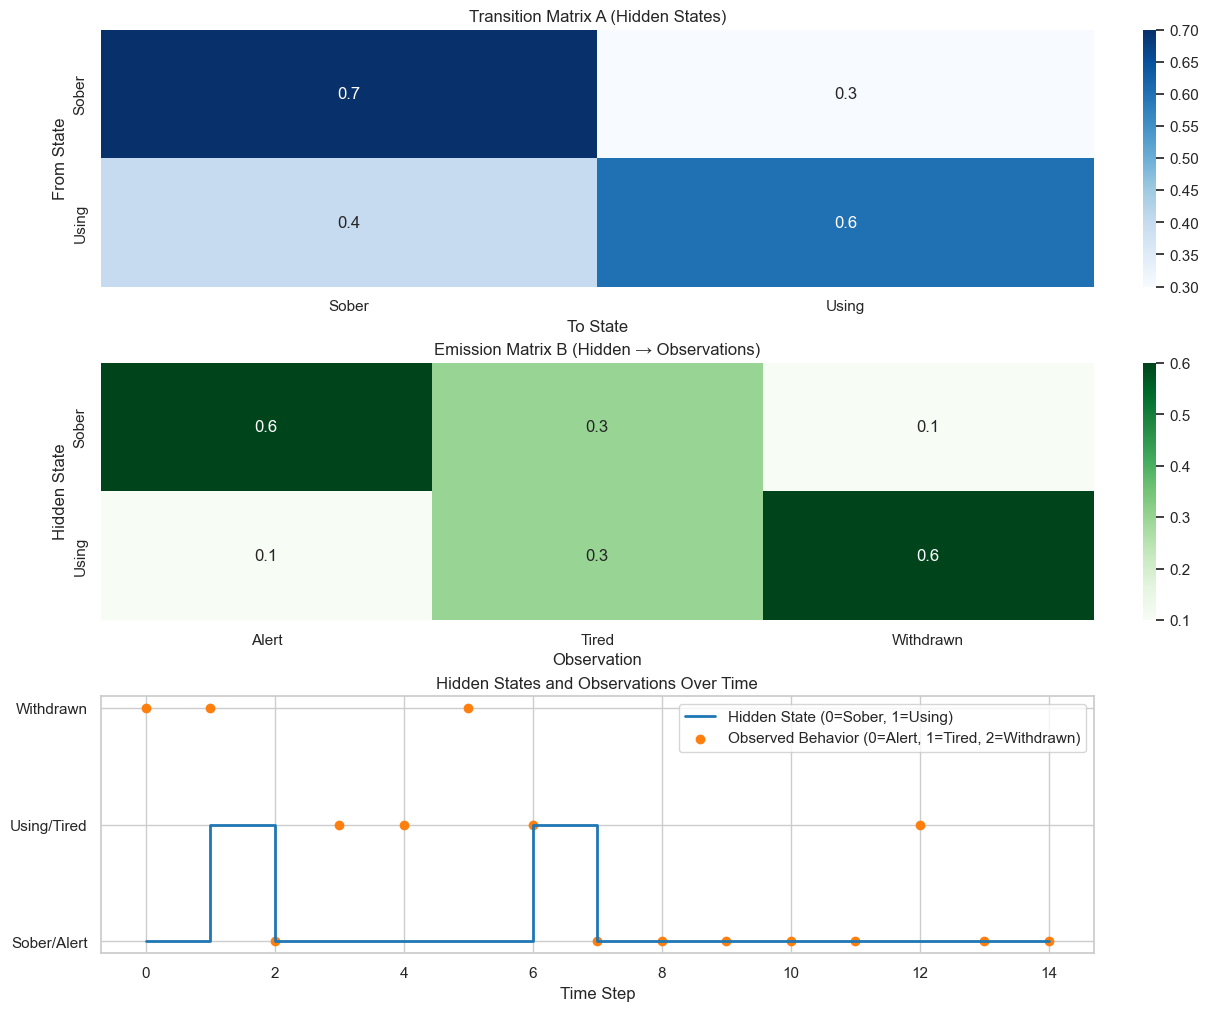

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define states and observations
states = ['Sober', 'Using']
observations = ['Alert', 'Tired', 'Withdrawn']

# Transition matrix A (hidden state to hidden state)
A = np.array([[0.7, 0.3],
              [0.4, 0.6]])

# Emission matrix B (hidden state to observations)
B = np.array([[0.6, 0.3, 0.1],
              [0.1, 0.3, 0.6]])

# Initial distribution π
pi = np.array([0.8, 0.2])

# Generate a sequence of states and observations
np.random.seed(42)
sequence_length = 15
hidden_states = []
observed_states = []

current_state = np.random.choice(len(states), p=pi)
hidden_states.append(current_state)
observed_states.append(np.random.choice(len(observations), p=B[current_state]))

for _ in range(1, sequence_length):
    current_state = np.random.choice(len(states), p=A[current_state])
    hidden_states.append(current_state)
    observed_states.append(np.random.choice(len(observations), p=B[current_state]))

# Prepare visuals
fig, axs = plt.subplots(3, 1, figsize=(12, 10), constrained_layout=True)

# Plot 1: Heatmap for Transition Matrix
sns.heatmap(A, annot=True, cmap='Blues', xticklabels=states, yticklabels=states, ax=axs[0])
axs[0].set_title("Transition Matrix A (Hidden States)")
axs[0].set_xlabel("To State")
axs[0].set_ylabel("From State")

# Plot 2: Heatmap for Emission Matrix
sns.heatmap(B, annot=True, cmap='Greens', xticklabels=observations, yticklabels=states, ax=axs[1])
axs[1].set_title("Emission Matrix B (Hidden → Observations)")
axs[1].set_xlabel("Observation")
axs[1].set_ylabel("Hidden State")

# Plot 3: State Sequence Timeline
x = np.arange(sequence_length)
axs[2].plot(x, hidden_states, label='Hidden State (0=Sober, 1=Using)', drawstyle='steps-post', color='tab:blue', linewidth=2)
axs[2].scatter(x, observed_states, label='Observed Behavior (0=Alert, 1=Tired, 2=Withdrawn)', color='tab:orange')
axs[2].set_yticks([0, 1, 2])
axs[2].set_yticklabels(['Sober/Alert', 'Using/Tired', 'Withdrawn'])
axs[2].set_title("Hidden States and Observations Over Time")
axs[2].set_xlabel("Time Step")
axs[2].legend()

plt.show()

This visualization **illustrates** how a Hidden Markov Model **generates a sequence of hidden states** and corresponding observable behaviors over time. The blue line shows the **underlying** (hidden) states, whether an individual is “Sober” or “Using”, while the orange points mark the **observed** behaviors, such as “Alert,” “Tired,” or “Withdrawn.” These observations are not direct indicators of the hidden state but are probabilistically linked to them through the emission matrix. This highlights the core function of an HMM: modeling systems where we can only infer the true state indirectly through observable data.

Now that we've constructed a system with hidden states and probabilistic observations using a Hidden Markov Model (HMM), we turn to the **central challenge of inference**: How can we recover or estimate the hidden states based on the observable data? 

Depending on the nature of the problem, whether the variables are continuous or discrete, and whether we seek full probability distributions or the most likely sequence of states, we have several powerful tools at our disposal.

One such tool is the **Kalman Filter**, which serves as a continuous-state analogue of Hidden Markov Models (HMMs). In this case, both the hidden states and observations are modeled as Gaussian random variables. The Kalman Filter is particularly useful in situations where the system dynamics are linear and the noise follows a Gaussian distribution. It is widely used in control systems, navigation, and econometrics. As Eisenstein (2019, pp. 161-164) explains, the forward-backward algorithm in discrete state spaces can be seen as a Bayesian state estimation, and its continuous counterpart is known as the Kalman smoother. Additionally, as Domingos (2015, p. 155) notes, when the states and observations are continuous variables instead of discrete ones, the HMM becomes a Kalman filter. This method is often used by economists to remove noise from time series data, such as GDP, inflation, and unemployment, where the true underlying values, such as actual GDP, are hidden states, and the reported figures are noisy observations.

#### Example: Kalman filter

Imagine you’re building the **brain for a self-driving car**. You're responsible for making sure it knows where it is on the road, even when it can’t see clearly. The GPS signals are noisy, and sensors like radar and lidar give you imperfect measurements. Still, the car must estimate its true position and velocity in real-time to avoid crashing into things.

In this scenario, our car moves along a straight road. It updates its position based on its previous speed and gets periodic, noisy GPS measurements. The Kalman Filter helps us fuse these noisy observations with our model of how the car moves, giving us a much cleaner estimate of its real position and velocity over time.

**Disclaimer**: This is an AI-generated simulation for illustrative and educational purposes only. It does not represent real vehicle data, sensor behavior, or engineering systems *(OpenAI, 2025)*.

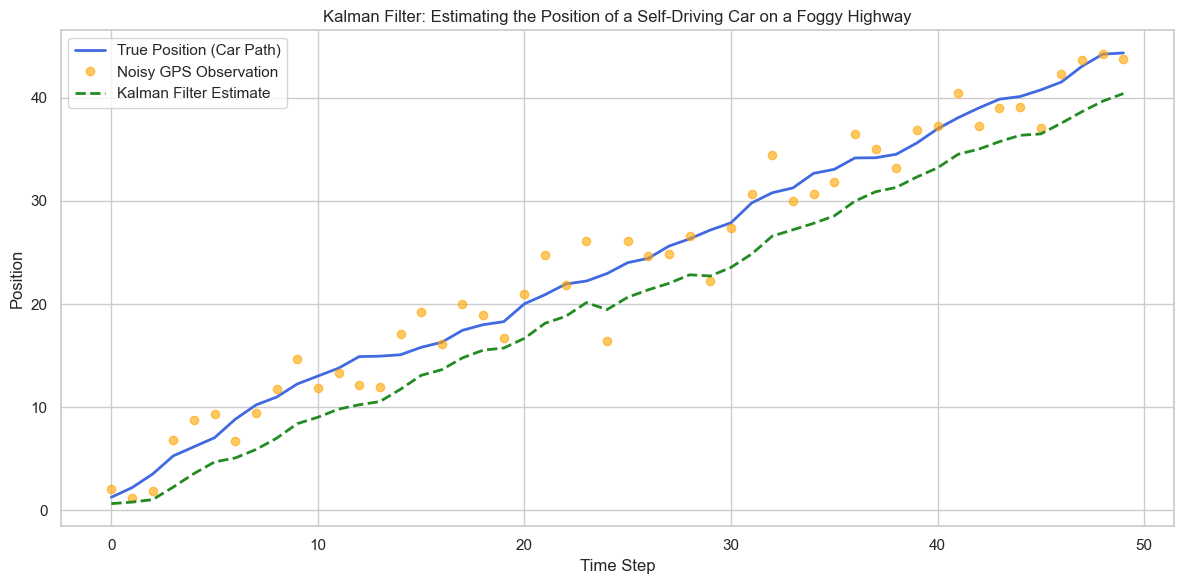

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Simulated "true" position of a self-driving car on a highway
n_steps = 50
true_position = np.cumsum(np.random.normal(loc=1.0, scale=0.5, size=n_steps))  # more motion
observed_position = true_position + np.random.normal(0, 2.5, size=n_steps)  # larger GPS noise

# Kalman Filter variables
estimated_position = np.zeros(n_steps)
est_error = np.zeros(n_steps)
Q = 0.1  # process variance (model uncertainty)
R = 2.5  # measurement variance (sensor noise)

# Initialization
x = 0.0  # initial estimate
P = 1.0  # initial estimate error

# Kalman Filter loop
for t in range(n_steps):
    # Prediction step
    x_pred = x
    P_pred = P + Q

    # Update step
    K = P_pred / (P_pred + R)
    x = x_pred + K * (observed_position[t] - x_pred)
    P = (1 - K) * P_pred

    estimated_position[t] = x
    est_error[t] = P

# Plotting with improved scale and story
plt.figure(figsize=(12, 6))
plt.plot(true_position, label='True Position (Car Path)', linewidth=2, color='royalblue')
plt.plot(observed_position, 'o', label='Noisy GPS Observation', alpha=0.6, color='orange')
plt.plot(estimated_position, '--', label='Kalman Filter Estimate', linewidth=2, color='forestgreen')
plt.title('Kalman Filter: Estimating the Position of a Self-Driving Car on a Foggy Highway')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Key Takeaways:** <br>
This example demonstrates how the Kalman Filter **effectively recovers a smooth and reliable estimate of a system’s true state**, even when observations are noisy or incomplete. The true path of the car (blue) is obscured by noisy GPS readings (orange), which vary due to signal interference or environmental uncertainty. The Kalman Filter estimate (green) tracks the true trajectory with remarkable accuracy by leveraging **assumptions of linear dynamics and Gaussian noise**. As Domingos (2015, *The Master Algorithm*, p. 155) explains, Kalman Filters are used in fields like econometrics, where true values such as GDP or inflation are hidden states inferred from noisy observations. Similarly, Eisenstein (2019, *Introduction to Natural Language Processing*, pp. 161–164) describes the Kalman Filter as the continuous-state-space analogue of the forward-backward algorithm in Hidden Markov Models, making it a cornerstone technique in autonomous navigation, aerospace systems, and time series modeling.

#### From Kalman to Baum-Welch: Learning HMM Parameters

So far, we’ve assumed we already know the transition and emission probabilities of our Hidden Markov Model (HMM). But in many real-world cases, those parameters aren’t given—they need to be learned from the data. This is where the **Baum-Welch algorithm** comes in.

Also known as the **EM (Expectation-Maximization)** algorithm for HMMs, Baum-Welch iteratively estimates both the transition matrix and the emission matrix by maximizing the likelihood of observed sequences. As Eisenstein (2019, pp. 161–162) puts it, the algorithm alternates between computing expected counts over possible state sequences (the "E-step") and maximizing parameters based on these expectations (the "M-step").

Bishop (2006, pp. 618–624) provides a detailed derivation of the algorithm using **forward-backward recursions** to efficiently compute expectations across all state paths. Similarly, in The Elements of Statistical Learning, Hastie, Tibshirani, and Friedman (2009, pp. 243–245) explain how this approach generalizes beyond HMMs to a wide class of latent-variable models, illustrating the power of EM for **problems with hidden structure**.

By using Baum-Welch, we transition from just using HMMs to actually training them—making them adaptive to real data and robust in dynamic environments such as speech recognition, bioinformatics, and financial modeling.

#### Example: Baum-Welch

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


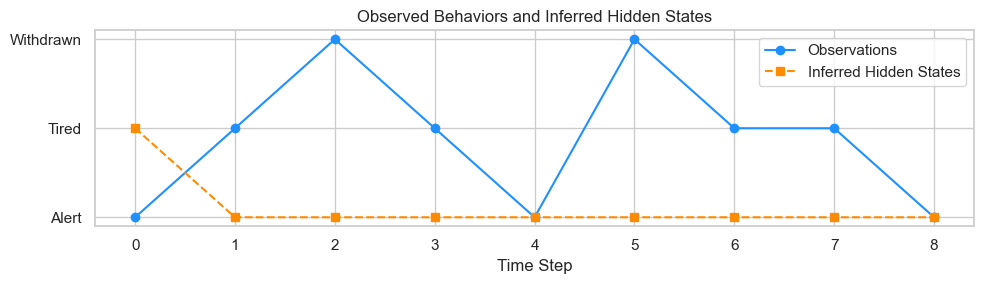

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

# Simulated observation sequence: 0 = Alert, 1 = Tired, 2 = Withdrawn
obs_seq = np.array([[0], [1], [2], [1], [0], [2], [1], [1], [0]])

# Create and fit HMM with 2 hidden states (e.g., Sober, Using)
model = hmm.MultinomialHMM(n_components=2, n_iter=100, random_state=42)
model.fit(obs_seq)

# Predict the hidden states
hidden_states = model.predict(obs_seq)

# Plot observations and inferred hidden states
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(range(len(obs_seq)), obs_seq.flatten(), 'o-', label='Observations', color='dodgerblue')
ax.plot(range(len(hidden_states)), hidden_states, 's--', label='Inferred Hidden States', color='darkorange')
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['Alert', 'Tired', 'Withdrawn'])
ax.set_xlabel('Time Step')
ax.set_title('Observed Behaviors and Inferred Hidden States')
ax.legend()
plt.tight_layout()
plt.show()

**Key takeaways:** <br>
In this example, we simulate a sequence of observed behaviors: Alert, Tired, and Withdrawn, which might be emitted from a hidden underlying condition, such as whether someone is Sober or Using. Using the Baum-Welch algorithm, implemented here via the hmmlearn library, the model learns the parameters of the Hidden Markov Model (HMM) in an unsupervised fashion from the observed sequence. It then infers the most likely hidden state at each time step.

This reflects how HMMs can be trained even when the actual hidden states are never observed directly. The Baum-Welch algorithm is an Expectation-Maximization (EM) technique that iteratively refines the model to maximize the likelihood of the observed data, as explained by Bishop (2006, p. 619).

#### Gibbs Sampling Overview
Gibbs sampling is an MCMC algorithm that is particularly useful when dealing with **high-dimensional problems involving latent variables**. The key idea behind Gibbs sampling is that instead of sampling from the entire joint distribution of the variables at once, it iteratively samples from the conditional distributions of each variable, given the current values of the others. 

As Eisenstein (2019, p. 110) explains, Gibbs sampling works by sampling each latent variable from its posterior distribution. This process is repeated for all latent variables, generating a Markov chain that is guaranteed to converge to the true joint distribution of the variables over time. This makes Gibbs sampling an effective tool for **probabilistic clustering** and other tasks involving latent variable models.

Hastie, Tibshirani, and Friedman (2009, p. 243) highlight that Gibbs sampling is **closely related to the Expectation-Maximization (EM)** algorithm, with the **key difference** being that Gibbs sampling samples from the conditional distributions rather than maximizing over them. The resulting Markov chain is guaranteed to converge to the stationary distribution of the joint distribution, thus making Gibbs sampling a **special case of the Metropolis-Hastings algorithm** *(Bishop, 2006, p. 542)*.

Bishop (2006, p. 546) further explains that Gibbs sampling considers one variable at a time, which creates strong dependencies between successive samples, making it important to account for this dependence when analyzing the results.

#### Example:

We will sample from a **bivariate** distribution, where the latent variables are $$ x_1 $$ and $$ x_2 $$ We assume the following:

$$
x_1 \mid x_2 \sim \mathcal{N}(3 + 2x_2, 1)
$$

$$
x_2 \mid x_1 \sim \mathcal{N}(1 + 0.5x_1, 1)
$$

This example will show how Gibbs sampling works in practice, iteratively sampling each variable from its conditional distribution.
As described by Hastie et al. in *The Elements of Statistical Learning* (2009, p. 243), Gibbs sampling is a Markov Chain Monte Carlo (MCMC) technique that generates samples from a joint distribution by iteratively sampling from the conditional distributions of each variable.

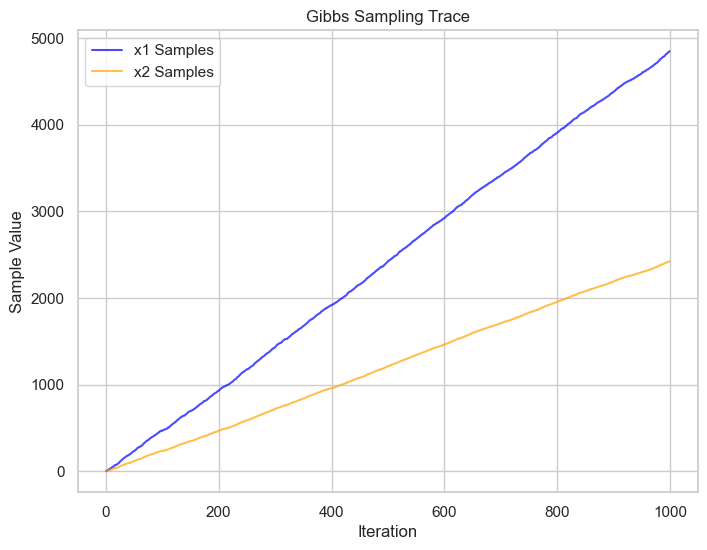

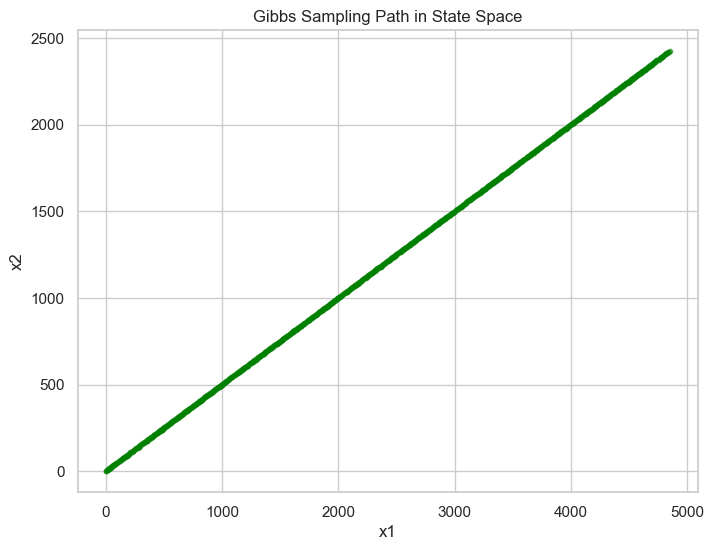

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Define the conditional distributions
def sample_x1(x2):
    return np.random.normal(3 + 2 * x2, 1)

def sample_x2(x1):
    return np.random.normal(1 + 0.5 * x1, 1)

# Gibbs sampling
n_samples = 1000
x1_samples = np.zeros(n_samples)
x2_samples = np.zeros(n_samples)

# Initialize
x1_samples[0] = np.random.normal(0, 1)
x2_samples[0] = np.random.normal(0, 1)

# Run Gibbs Sampling
for i in range(1, n_samples):
    x1_samples[i] = sample_x1(x2_samples[i-1])
    x2_samples[i] = sample_x2(x1_samples[i])

# Plot the trajectory of the samples
plt.figure(figsize=(8, 6))
plt.plot(range(n_samples), x1_samples, label='x1 Samples', color='blue', alpha=0.7)
plt.plot(range(n_samples), x2_samples, label='x2 Samples', color='orange', alpha=0.7)
plt.title('Gibbs Sampling Trace')
plt.xlabel('Iteration')
plt.ylabel('Sample Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the trajectory in the state space
plt.figure(figsize=(8, 6))
plt.scatter(x1_samples, x2_samples, marker='o', color='green', alpha=0.5, s=10)
plt.title('Gibbs Sampling Path in State Space')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()

**What exactly do we see on those graphs?** <br>

1.   The **first plot** shows the trace of both X1 and X2 over time (i.e. as the Gibbs sampling progresses). This illustrates the idea of **how the values evolve** over the iterations. As the iterations increase, the values tend to stabilize, illustrating the convergence of the Markov chain.

2. The **second plot** visualizes **how the samples move through the state space** (i.e. in the X1-X2 plane). Each point represents a sample from the Markov chain, and the distribution of points over time shows the **convergence** of the Gibbs sampler towards the true joint distribution. The more samples we take, the more densely populated the state space becomes, reflecting the true distribution.

The trajectory of the samples helps illustrate the dynamic nature of Gibbs sampling, which is **guaranteed to converge** to the true distribution *(Hastie et al., 2009, p. 243)*.

#### Viterbi Algorithm Overview
The Viterbi Algorithm is an efficient **dynamic programming technique** used to find the **most probable sequence of hidden states** in a Hidden Markov Model (HMM). It is particularly useful when the **goal is to identify the best sequence** of states based on observed data, rather than simply estimating individual state probabilities. The Viterbi algorithm employs a max-sum approach, optimizing the search for the most likely path by considering the product of transition and emission probabilities at each step. 

One of its **key advantages** is that it **works with log probabilities**, which helps avoid numerical instability and eliminates the need for re-scaling, as seen in the forward-backward algorithm *(Bishop, 2006, p. 629)*. This approach allows for efficient computation with a time complexity that grows linearly with the length of the observed sequence *(Eisenstein, 2019, p. 163)*.

In practical applications, the Viterbi algorithm is widely used in fields like speech recognition, biological sequence alignment, and error correction. The algorithm computes a matrix of probabilities for each state at each time step, then backtracks to identify the sequence of states that maximizes the overall probability. As Bishop (2006, p. 629) notes, this makes the algorithm both computationally efficient and highly scalable for real-world applications that involve sequential data.

#### Example: 

In [68]:
import numpy as np

# Define the HMM components: transition probabilities, emission probabilities, and initial probabilities
states = ["Rainy", "Sunny"]
observations = ["Walk", "Shop", "Clean"]
start_probs = np.array([0.6, 0.4])  # Initial state probabilities
trans_probs = np.array([[0.7, 0.3], [0.4, 0.6]])  # Transition probabilities
emit_probs = np.array([[0.1, 0.4, 0.5], [0.6, 0.3, 0.1]])  # Emission probabilities

# Map observations to indices
obs_map = {obs: i for i, obs in enumerate(observations)}

# The sequence of observations
obs_seq = ["Walk", "Shop", "Clean"]
obs_indices = [obs_map[obs] for obs in obs_seq]

# Initialize the Viterbi variables
n_states = len(states)
n_observations = len(obs_seq)

# Initialize the dynamic programming table (delta) and the backpointer table (psi)
# The delta table stores the highest probabilities of being in a particular state at a given time
delta = np.zeros((n_states, n_observations))
# The psi table tracks the most probable previous state for backtracking.
psi = np.zeros((n_states, n_observations), dtype=int)

# Initialize base cases (t == 0):
# This step initializes the first column of the delta table using the initial probabilities and the emission probabilities.
for s in range(n_states):
    delta[s, 0] = start_probs[s] * emit_probs[s, obs_indices[0]]

# Recursion step (for t > 0):
# This step calculates the most probable path to each state for each observation.
for t in range(1, n_observations):
    for s in range(n_states):
        trans_prob = delta[:, t-1] * trans_probs[:, s]
        psi[s, t] = np.argmax(trans_prob)  # Store the state that led to the max probability
        delta[s, t] = np.max(trans_prob) * emit_probs[s, obs_indices[t]]

# Termination: Find the most probable final state
best_last_state = np.argmax(delta[:, n_observations-1])

# Backtrack to find the most probable sequence of states
best_path = [best_last_state]
for t in range(n_observations-1, 0, -1):
    best_path.insert(0, psi[best_path[0], t])

# Convert the best state indices to state names
best_path_states = [states[s] for s in best_path]

# Display the results
print("Most probable sequence of states:")
print(best_path_states)

Most probable sequence of states:
['Sunny', 'Rainy', 'Rainy']


**Key takeaways:** <br>
In this code example, we applied the Viterbi algorithm to find the most probable sequence of hidden states given a set of observations. This method, as discussed by Bishop (2006), efficiently searches through all possible paths using the max-sum approach and operates on log probabilities, allowing for efficient computation even in long sequences. By using the Viterbi algorithm, we learned how to estimate the most likely state sequence in a Hidden Markov Model, which is essential in many real-world applications like speech recognition and biological sequence alignment *(Bishop, 2006)*.

### 10. Conclusion

In this tutorial, we explored the powerful concept of Markov Chain Monte Carlo (MCMC) methods and their applications in solving complex problems where direct analytical solutions are difficult or impossible. We began with a foundational understanding of Monte Carlo simulations and the role of stochastic processes in sampling and estimation. Through Python code examples, we gained a deeper intuition of how MCMC methods, like the **Metropolis-Hastings algorithm**, **Gibbs sampling**, and the **Viterbi algorithm**, can be used to sample from complex distributions and solve real-world problems, such as probabilistic inference and sequence prediction.

We also delved into important concepts such as the **Law of Large Numbers**, **resampling methods**, and the **relationship between MCMC and Bayesian inference**, enhancing our understanding of the statistical underpinnings that make these methods so powerful. By applying these techniques to synthetic datasets, we were able to demonstrate their practical utility and limitations, and how they can be scaled to tackle high-dimensional, complex data.

Furthermore, this tutorial highlighted the importance of computational efficiency in applying these algorithms, showing how methods like the **Viterbi algorithm** and **Kalman filters** optimize our search for the most probable states in probabilistic models. As we explored advanced topics in MCMC, we saw how these algorithms not only provide solutions for various types of problems but also form the backbone of many modern machine learning techniques.

Ultimately, we now have a better understanding of how MCMC algorithms can be leveraged for data analysis, probabilistic modeling, and prediction, providing powerful tools to address challenges across numerous fields, from AI and machine learning to economics and engineering.

The methods introduced here lay the groundwork for further exploration in machine learning, and their applications continue to expand as we gain more computational resources and refine our understanding of probabilistic modeling. We hope this tutorial has provided you with both the theoretical insights and practical coding experience necessary to confidently use MCMC techniques in your own projects. Cheers!

### 11. Works Cited

Amazon Web Services, Inc. (n.d.). *AWS Cloud Practitioner Essentials (Second Edition)*. Retrieved from https://www.aws.training

Bishop, C. M. (2006). *Pattern recognition and machine learning* (pp. 610–635). Springer.

Domingos, P. (2015). *The master algorithm: How the quest for the ultimate learning machine will remake our world* (pp.155, 158-166). Basic Books.

Eisenstein, J. (2019). *Introduction to Natural Language Processing* (pp. 161-164). MIT Press.

Feller, W. (1968). *An Introduction to Probability Theory and Its Applications* (3rd ed., Vol. 1, pp. 384–390). Wiley

Geron, A. (2019). *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed.)* (pp.368-370). O'Reilly Media.

Goldsman, D. (2024). *Simulation course lectures* [Class lecture]. Georgia Institute of Technology.

Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The elements of statistical learning: Data mining, inference, and prediction* (2nd ed., pp. 243-245). Springer.

Linoff, G. S., & Berry, M. J. A. (2011). *Data mining techniques: For marketing, sales, and customer relationship management* (3rd ed., pp. 443-455). Wiley.

Mohri, M., Rostamizadeh, A., & Talwalkar, A. (2018). *Foundations of machine learning (2nd ed.)* (p.394). MIT Press

Newman, M. (2010). *Networks: An Introduction* (p. 390). Oxford University Press.

OpenAI. (2024). *ChatGPT (April 2024 version)* [Large language model]. https://openai.com/chatgpt

Page, S. E. (2018). *The model thinker: What you need to know to make data work for you* (pp. 121–126, 339–343). Basic Books.

Weber, I. (n.d.). *Monte Carlo simulations in Python* [Online course]. DataCamp. https://app.datacamp.com/learn/courses/monte-carlo-simulations-in-python
